In [10]:
import os
import json
import itertools
import random
from collections import Counter
from tqdm import tqdm

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt

from esper.widget import *
import esper.face_embeddings as face_embeddings

def query_faces(ids):
    faces = Face.objects.filter(id__in=ids)
    return faces.values(
        'id', 'bbox_y1', 'bbox_y2', 'bbox_x1', 'bbox_x2',
        'frame__number', 'frame__video__id', 'frame__video__fps',
        'shot__min_frame', 'shot__max_frame')

def query_faces_result(faces, expand_bbox=0.05):
    """Replaces qs_to_result"""
    result = []
    for face in faces:
        if (face.get('shot__min_frame') is not None and
                face.get('shot__max_frame') is not None):
            min_frame = int(
                (face['shot__min_frame'] +
                 face['shot__max_frame']) / 2)
        else:
            min_frame = face['frame__number']
        face_result = {
            'type': 'flat', 'label': '',
            'elements': [{
                'objects': [{
                    'id': face['id'],
                    'background': False,
                    'type': 'bbox',
                    'bbox_y1': max(face['bbox_y1'] - expand_bbox, 0),
                    'bbox_y2': min(face['bbox_y2'] + expand_bbox, 1),
                    'bbox_x1': max(face['bbox_x1'] - expand_bbox, 0),
                    'bbox_x2': min(face['bbox_x2'] + expand_bbox, 1),
                }],
                'min_frame': min_frame,
                'video': face['frame__video__id']
            }]
        }
        result.append(face_result)
    return {'type': 'Face', 'count': 0, 'result': result}

def plot_confusion_matrix(y_truth, y_pred, normalize=True):
    cm = confusion_matrix(y_truth, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    classes = ['Non-black', 'Black']
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
    plt.title('Black vs. non-black confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Hand label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def print_pred_dist(pred):
    n = len(pred)
    counts = Counter([t[1] for t in pred])
    for k in sorted(counts):
        print('', '{:0.2f}'.format(k), counts[k] / n)

In [11]:
with open('/app/data/black.1k.random.json') as f:
    hand_labels_train = {int(k): int(v) for k, v in json.load(f).items()}
train_ids = [i for i in hand_labels_train]
train_y = [hand_labels_train[i] for i in train_ids]
del hand_labels_train
    
with open('/app/data/black.250.random.json') as f:
    hand_labels_test = {int(k): int(v) for k, v in json.load(f).items()}
test_ids = [i for i in hand_labels_test]
test_y = [hand_labels_test[i] for i in test_ids]
del hand_labels_test

Test dist:
 0.00 0.69377990430622
 0.07 0.09617224880382776
 0.13 0.045454545454545456
 0.20 0.022966507177033493
 0.27 0.011004784688995215
 0.33 0.00909090909090909
 0.40 0.005263157894736842
 0.47 0.007177033492822967
 0.53 0.005263157894736842
 0.60 0.004784688995215311
 0.67 0.005263157894736842
 0.73 0.0066985645933014355
 0.80 0.010526315789473684
 0.87 0.010047846889952153
 0.93 0.018660287081339714
 1.00 0.04784688995215311
train dist:
 0.00 0.6997903075489282
 0.07 0.10589468779123952
 0.13 0.04287045666356011
 0.20 0.022833178005591797
 0.27 0.008271202236719477
 0.33 0.008271202236719477
 0.40 0.004543336439888164
 0.47 0.005358807082945014
 0.53 0.005242311276794035
 0.60 0.004193849021435228
 0.67 0.003727865796831314
 0.73 0.006640260950605778
 0.80 0.006756756756756757
 0.87 0.010834109972041006
 0.93 0.019105312208760484
 1.00 0.045666356011183594
Train accuracy: 0.9733224603914259
Train f1-score: 0.8876900441392841
Non-normalized train confusion matrix:


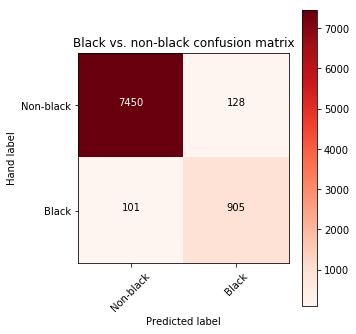

Normalized train confusion matrix:


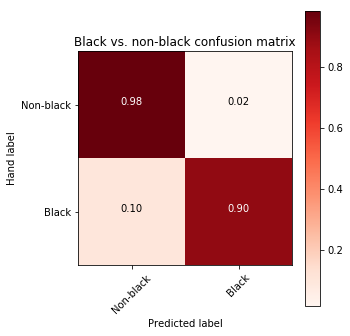

Test accuracy: 0.9631578947368421
Test f1-score: 0.8622540250447227
Non-normalized test confusion matrix:


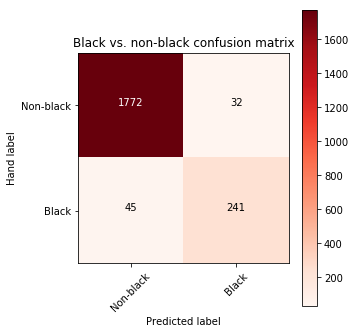

Normalized test confusion matrix:


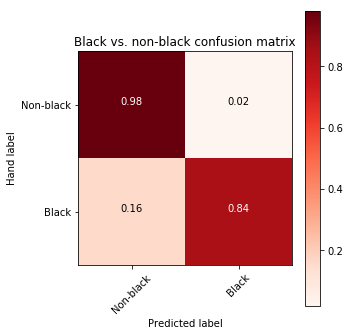

In [12]:
PRED_THRESHOLD = 0.3
K = 15

test_pred_r = face_embeddings.knn_predict(
    train_ids, train_y, k=K, ids=test_ids)
test_pred_d = {k: 0 if v < PRED_THRESHOLD else 1
               for k, v in test_pred_r}
test_pred = [test_pred_d[i] for i in test_ids]

train_pred_r = face_embeddings.knn_predict(
    train_ids, train_y, k=K, ids=train_ids)
train_pred_d = {k: 0 if v < PRED_THRESHOLD else 1
                for k, v in train_pred_r}
train_pred = [train_pred_d[i] for i in train_ids]

print('Train pred dist:')
print_pred_dist(train_pred_r)
print('Train accuracy:', accuracy_score(train_y, train_pred))
print('Train f1-score:', f1_score(train_y, train_pred))
print('Non-normalized train confusion matrix:')
plot_confusion_matrix(train_y, train_pred, False)
print('Normalized train confusion matrix:')
plot_confusion_matrix(train_y, train_pred)

print('Test pred dist:')
print_pred_dist(test_pred_r)
print('Test accuracy:', accuracy_score(test_y, test_pred))
print('Test f1-score:', f1_score(test_y, test_pred))
print('Non-normalized test confusion matrix:')
plot_confusion_matrix(test_y, test_pred, False)
print('Normalized test confusion matrix:')
plot_confusion_matrix(test_y, test_pred)

# False Positives

In [ ]:
# data_iter = zip(test_ids, test_pred, test_y)
data_iter = zip(train_ids, train_pred, train_y)

fp_ids = [i for i, y_pred, y_true in data_iter
          if y_pred == 1 and y_true == 0]
fp_faces = query_faces(fp_ids)
fp_widget = esper_widget(query_faces_result(fp_faces))
fp_widget

In [ ]:
fp_selected = [fp_faces[i]['id'] for i in fp_widget.selected]
fp_selected

# False Negative

In [ ]:
# data_iter = zip(test_ids, test_pred, test_y)
data_iter = zip(train_ids, train_pred, train_y)

fn_ids = [i for i, y_pred, y_true in data_iter
          if y_pred == 0 and y_true == 1]
fn_faces = query_faces(fn_ids)
fn_widget = esper_widget(query_faces_result(fn_faces))
fn_widget

In [ ]:
fn_selected = [fn_faces[i]['id'] for i in fn_widget.selected]
fn_selected

# Run KNN on Entire Dataset

In [ ]:
RACE_PRED_DIR = '/app/data/race_pred/'
if not os.path.exists(RACE_PRED_DIR):
    os.makedirs(RACE_PRED_DIR)

In [14]:
batch_size = 100000
max_idx = face_embeddings.count()
max_face_id = face_embeddings.ids(max_idx - 1, 1)[0]
# print('Max face id:', max_face_id)
for i in tqdm(range(0, max_face_id, batch_size)):
    batch_path = os.path.join(RACE_PRED_DIR, '{}.json'.format(i))
    if not os.path.exists(batch_path):
        batch_face_ids = list(range(i, i + batch_size))
        batch_face_ids = [
            a for a, b in zip(batch_face_ids, face_embeddings.exists(batch_face_ids))
            if b == True
        ]
        batch_pred = face_embeddings.knn_predict(
            train_ids, train_y, k=15, ids=batch_face_ids)
        with open(batch_path, 'w') as f:
            json.dump(batch_pred, f)



  0%|                                                                                                                              | 0/3456 [00:00<?, ?it/s]

  0%|                                                                                                                   | 1/3456 [00:11<11:04:47, 11.54s/it]

  0%|                                                                                                                   | 2/3456 [00:23<11:03:59, 11.53s/it]

  0%|                                                                                                                   | 3/3456 [00:34<11:05:12, 11.56s/it]

  0%|▏                                                                                                                  | 4/3456 [00:46<11:07:19, 11.60s/it]

  0%|▏                                                                                                                  | 5/3456 [00:57<11:05:57, 11.58s/it]

  0%|▏                                            

  1%|█▌                                                                                                                | 49/3456 [09:27<10:58:44, 11.60s/it]

  1%|█▋                                                                                                                | 50/3456 [09:39<10:57:51, 11.59s/it]

  1%|█▋                                                                                                                | 51/3456 [09:50<10:58:25, 11.60s/it]

  2%|█▋                                                                                                                | 52/3456 [10:02<10:57:22, 11.59s/it]

  2%|█▋                                                                                                                | 53/3456 [10:13<10:57:58, 11.60s/it]

  2%|█▊                                                                                                                | 54/3456 [10:25<10:56:54, 11.59s/it]

  2%|█▊                                             

  3%|███▏                                                                                                              | 98/3456 [18:54<10:47:50, 11.58s/it]

  3%|███▎                                                                                                              | 99/3456 [19:06<10:46:37, 11.56s/it]

  3%|███▎                                                                                                             | 100/3456 [19:17<10:46:44, 11.56s/it]

  3%|███▎                                                                                                             | 101/3456 [19:29<10:46:08, 11.56s/it]

  3%|███▎                                                                                                             | 102/3456 [19:40<10:46:13, 11.56s/it]

  3%|███▎                                                                                                             | 103/3456 [19:52<10:49:32, 11.62s/it]

  3%|███▍                                           

  4%|████▊                                                                                                            | 147/3456 [28:23<10:39:08, 11.59s/it]

  4%|████▊                                                                                                            | 148/3456 [28:34<10:37:11, 11.56s/it]

  4%|████▊                                                                                                            | 149/3456 [28:46<10:35:30, 11.53s/it]

  4%|████▉                                                                                                            | 150/3456 [28:57<10:34:05, 11.51s/it]

  4%|████▉                                                                                                            | 151/3456 [29:08<10:33:23, 11.50s/it]

  4%|████▉                                                                                                            | 152/3456 [29:20<10:32:47, 11.49s/it]

  4%|█████                                          

  6%|██████▍                                                                                                          | 196/3456 [37:48<10:25:53, 11.52s/it]

  6%|██████▍                                                                                                          | 197/3456 [38:00<10:24:39, 11.50s/it]

  6%|██████▍                                                                                                          | 198/3456 [38:11<10:24:19, 11.50s/it]

  6%|██████▌                                                                                                          | 199/3456 [38:23<10:25:30, 11.52s/it]

  6%|██████▌                                                                                                          | 200/3456 [38:34<10:25:34, 11.53s/it]

  6%|██████▌                                                                                                          | 201/3456 [38:46<10:25:31, 11.53s/it]

  6%|██████▌                                        

  7%|████████                                                                                                         | 245/3456 [47:23<10:18:41, 11.56s/it]

  7%|████████                                                                                                         | 246/3456 [47:34<10:17:28, 11.54s/it]

  7%|████████                                                                                                         | 247/3456 [47:46<10:15:54, 11.52s/it]

  7%|████████                                                                                                         | 248/3456 [47:57<10:15:52, 11.52s/it]

  7%|████████▏                                                                                                        | 249/3456 [48:09<10:16:18, 11.53s/it]

  7%|████████▏                                                                                                        | 250/3456 [48:20<10:16:10, 11.53s/it]

  7%|████████▏                                      

  9%|█████████▌                                                                                                       | 294/3456 [56:49<10:07:53, 11.53s/it]

  9%|█████████▋                                                                                                       | 295/3456 [57:01<10:07:18, 11.53s/it]

  9%|█████████▋                                                                                                       | 296/3456 [57:12<10:06:28, 11.52s/it]

  9%|█████████▋                                                                                                       | 297/3456 [57:24<10:05:48, 11.51s/it]

  9%|█████████▋                                                                                                       | 298/3456 [57:36<10:06:02, 11.51s/it]

  9%|█████████▊                                                                                                       | 299/3456 [57:47<10:10:51, 11.61s/it]

  9%|█████████▊                                     

 10%|███████████                                                                                                    | 343/3456 [1:06:22<10:05:41, 11.67s/it]

 10%|███████████                                                                                                    | 344/3456 [1:06:34<10:02:43, 11.62s/it]

 10%|███████████                                                                                                    | 345/3456 [1:06:45<10:02:02, 11.61s/it]

 10%|███████████                                                                                                    | 346/3456 [1:06:57<10:00:24, 11.58s/it]

 10%|███████████▏                                                                                                    | 347/3456 [1:07:09<9:59:54, 11.58s/it]

 10%|███████████▎                                                                                                    | 348/3456 [1:07:20<9:59:03, 11.56s/it]

 10%|███████████▎                                   

 11%|████████████▋                                                                                                   | 392/3456 [1:15:49<9:49:28, 11.54s/it]

 11%|████████████▋                                                                                                   | 393/3456 [1:16:00<9:50:10, 11.56s/it]

 11%|████████████▊                                                                                                   | 394/3456 [1:16:12<9:50:26, 11.57s/it]

 11%|████████████▊                                                                                                   | 395/3456 [1:16:23<9:49:51, 11.56s/it]

 11%|████████████▊                                                                                                   | 396/3456 [1:16:35<9:49:23, 11.56s/it]

 11%|████████████▊                                                                                                   | 397/3456 [1:16:46<9:48:51, 11.55s/it]

 12%|████████████▉                                  

 13%|██████████████▎                                                                                                 | 441/3456 [1:25:14<9:32:09, 11.39s/it]

 13%|██████████████▎                                                                                                 | 442/3456 [1:25:26<9:33:04, 11.41s/it]

 13%|██████████████▎                                                                                                 | 443/3456 [1:25:37<9:34:21, 11.44s/it]

 13%|██████████████▍                                                                                                 | 444/3456 [1:25:49<9:33:44, 11.43s/it]

 13%|██████████████▍                                                                                                 | 445/3456 [1:26:00<9:35:44, 11.47s/it]

 13%|██████████████▍                                                                                                 | 446/3456 [1:26:12<9:36:22, 11.49s/it]

 13%|██████████████▍                                

 14%|███████████████▉                                                                                                | 490/3456 [1:34:46<9:28:35, 11.50s/it]

 14%|███████████████▉                                                                                                | 491/3456 [1:34:58<9:30:17, 11.54s/it]

 14%|███████████████▉                                                                                                | 492/3456 [1:35:09<9:31:18, 11.56s/it]

 14%|███████████████▉                                                                                                | 493/3456 [1:35:21<9:29:41, 11.54s/it]

 14%|████████████████                                                                                                | 494/3456 [1:35:32<9:29:21, 11.53s/it]

 14%|████████████████                                                                                                | 495/3456 [1:35:44<9:28:22, 11.52s/it]

 14%|████████████████                               

 16%|█████████████████▍                                                                                              | 539/3456 [1:44:07<9:13:35, 11.39s/it]

 16%|█████████████████▌                                                                                              | 540/3456 [1:44:19<9:16:24, 11.45s/it]

 16%|█████████████████▌                                                                                              | 541/3456 [1:44:31<9:18:58, 11.51s/it]

 16%|█████████████████▌                                                                                              | 542/3456 [1:44:42<9:20:31, 11.54s/it]

 16%|█████████████████▌                                                                                              | 543/3456 [1:44:53<9:14:08, 11.41s/it]

 16%|█████████████████▋                                                                                              | 544/3456 [1:45:04<9:03:13, 11.19s/it]

 16%|█████████████████▋                             

 17%|███████████████████                                                                                             | 588/3456 [1:53:39<9:14:07, 11.59s/it]

 17%|███████████████████                                                                                             | 589/3456 [1:53:51<9:13:33, 11.58s/it]

 17%|███████████████████                                                                                             | 590/3456 [1:54:02<9:14:04, 11.60s/it]

 17%|███████████████████▏                                                                                            | 591/3456 [1:54:14<9:14:35, 11.61s/it]

 17%|███████████████████▏                                                                                            | 592/3456 [1:54:25<9:09:21, 11.51s/it]

 17%|███████████████████▏                                                                                            | 593/3456 [1:54:37<9:10:52, 11.54s/it]

 17%|███████████████████▎                           

 18%|████████████████████▋                                                                                           | 637/3456 [2:03:05<9:01:32, 11.53s/it]

 18%|████████████████████▋                                                                                           | 638/3456 [2:03:16<9:00:04, 11.50s/it]

 18%|████████████████████▋                                                                                           | 639/3456 [2:03:28<9:00:29, 11.51s/it]

 19%|████████████████████▋                                                                                           | 640/3456 [2:03:39<9:00:11, 11.51s/it]

 19%|████████████████████▊                                                                                           | 641/3456 [2:03:51<9:01:37, 11.54s/it]

 19%|████████████████████▊                                                                                           | 642/3456 [2:04:02<9:02:46, 11.57s/it]

 19%|████████████████████▊                          

 20%|██████████████████████▏                                                                                         | 686/3456 [2:12:38<9:02:53, 11.76s/it]

 20%|██████████████████████▎                                                                                         | 687/3456 [2:12:49<8:58:44, 11.67s/it]

 20%|██████████████████████▎                                                                                         | 688/3456 [2:13:01<8:56:37, 11.63s/it]

 20%|██████████████████████▎                                                                                         | 689/3456 [2:13:12<8:54:57, 11.60s/it]

 20%|██████████████████████▎                                                                                         | 690/3456 [2:13:24<8:54:08, 11.59s/it]

 20%|██████████████████████▍                                                                                         | 691/3456 [2:13:35<8:49:29, 11.49s/it]

 20%|██████████████████████▍                        

 21%|███████████████████████▊                                                                                        | 735/3456 [2:22:03<8:42:58, 11.53s/it]

 21%|███████████████████████▊                                                                                        | 736/3456 [2:22:15<8:43:22, 11.54s/it]

 21%|███████████████████████▉                                                                                        | 737/3456 [2:22:26<8:43:16, 11.55s/it]

 21%|███████████████████████▉                                                                                        | 738/3456 [2:22:38<8:43:08, 11.55s/it]

 21%|███████████████████████▉                                                                                        | 739/3456 [2:22:49<8:41:50, 11.52s/it]

 21%|███████████████████████▉                                                                                        | 740/3456 [2:23:01<8:42:18, 11.54s/it]

 21%|████████████████████████                       

 23%|█████████████████████████▍                                                                                      | 784/3456 [2:31:28<8:34:46, 11.56s/it]

 23%|█████████████████████████▍                                                                                      | 785/3456 [2:31:40<8:41:30, 11.71s/it]

 23%|█████████████████████████▍                                                                                      | 786/3456 [2:31:54<9:14:33, 12.46s/it]

 23%|█████████████████████████▌                                                                                      | 787/3456 [2:32:09<9:47:01, 13.20s/it]

 23%|█████████████████████████▌                                                                                      | 788/3456 [2:32:21<9:31:50, 12.86s/it]

 23%|█████████████████████████▌                                                                                      | 789/3456 [2:32:33<9:15:33, 12.50s/it]

 23%|█████████████████████████▌                     

 24%|██████████████████████████▉                                                                                     | 833/3456 [2:41:00<8:22:58, 11.51s/it]

 24%|███████████████████████████                                                                                     | 834/3456 [2:41:12<8:23:36, 11.52s/it]

 24%|███████████████████████████                                                                                     | 835/3456 [2:41:23<8:25:42, 11.58s/it]

 24%|███████████████████████████                                                                                     | 836/3456 [2:41:35<8:25:50, 11.58s/it]

 24%|███████████████████████████▏                                                                                    | 837/3456 [2:41:46<8:23:56, 11.54s/it]

 24%|███████████████████████████▏                                                                                    | 838/3456 [2:41:58<8:23:34, 11.54s/it]

 24%|███████████████████████████▏                   

 26%|████████████████████████████▌                                                                                   | 882/3456 [2:50:32<8:17:44, 11.60s/it]

 26%|████████████████████████████▌                                                                                   | 883/3456 [2:50:43<8:16:40, 11.58s/it]

 26%|████████████████████████████▋                                                                                   | 884/3456 [2:50:55<8:15:55, 11.57s/it]

 26%|████████████████████████████▋                                                                                   | 885/3456 [2:51:07<8:15:13, 11.56s/it]

 26%|████████████████████████████▋                                                                                   | 886/3456 [2:51:18<8:15:15, 11.56s/it]

 26%|████████████████████████████▋                                                                                   | 887/3456 [2:51:30<8:13:53, 11.54s/it]

 26%|████████████████████████████▊                  

 27%|██████████████████████████████▏                                                                                 | 931/3456 [2:59:58<8:06:17, 11.56s/it]

 27%|██████████████████████████████▏                                                                                 | 932/3456 [3:00:09<8:05:06, 11.53s/it]

 27%|██████████████████████████████▏                                                                                 | 933/3456 [3:00:21<8:05:05, 11.54s/it]

 27%|██████████████████████████████▎                                                                                 | 934/3456 [3:00:32<8:04:15, 11.52s/it]

 27%|██████████████████████████████▎                                                                                 | 935/3456 [3:00:44<8:03:53, 11.52s/it]

 27%|██████████████████████████████▎                                                                                 | 936/3456 [3:00:55<8:03:05, 11.50s/it]

 27%|██████████████████████████████▎                

 28%|███████████████████████████████▊                                                                                | 980/3456 [3:09:30<7:56:52, 11.56s/it]

 28%|███████████████████████████████▊                                                                                | 981/3456 [3:09:41<7:56:00, 11.54s/it]

 28%|███████████████████████████████▊                                                                                | 982/3456 [3:09:53<7:55:40, 11.54s/it]

 28%|███████████████████████████████▊                                                                                | 983/3456 [3:10:05<7:55:29, 11.54s/it]

 28%|███████████████████████████████▉                                                                                | 984/3456 [3:10:16<7:54:50, 11.53s/it]

 29%|███████████████████████████████▉                                                                                | 985/3456 [3:10:28<7:55:47, 11.55s/it]

 29%|███████████████████████████████▉               

 30%|█████████████████████████████████                                                                              | 1029/3456 [3:18:56<7:47:40, 11.56s/it]

 30%|█████████████████████████████████                                                                              | 1030/3456 [3:19:07<7:47:42, 11.57s/it]

 30%|█████████████████████████████████                                                                              | 1031/3456 [3:19:19<7:46:31, 11.54s/it]

 30%|█████████████████████████████████▏                                                                             | 1032/3456 [3:19:30<7:46:04, 11.54s/it]

 30%|█████████████████████████████████▏                                                                             | 1033/3456 [3:19:42<7:45:05, 11.52s/it]

 30%|█████████████████████████████████▏                                                                             | 1034/3456 [3:19:54<7:45:33, 11.53s/it]

 30%|█████████████████████████████████▏             

 31%|██████████████████████████████████▌                                                                            | 1078/3456 [3:28:22<7:38:48, 11.58s/it]

 31%|██████████████████████████████████▋                                                                            | 1079/3456 [3:28:34<7:38:21, 11.57s/it]

 31%|██████████████████████████████████▋                                                                            | 1080/3456 [3:28:45<7:38:20, 11.57s/it]

 31%|██████████████████████████████████▋                                                                            | 1081/3456 [3:28:57<7:37:14, 11.55s/it]

 31%|██████████████████████████████████▊                                                                            | 1082/3456 [3:29:08<7:36:35, 11.54s/it]

 31%|██████████████████████████████████▊                                                                            | 1083/3456 [3:29:20<7:35:23, 11.51s/it]

 31%|██████████████████████████████████▊            

 33%|████████████████████████████████████▏                                                                          | 1127/3456 [3:37:47<8:24:35, 13.00s/it]

 33%|████████████████████████████████████▏                                                                          | 1128/3456 [3:37:59<8:12:19, 12.69s/it]

 33%|████████████████████████████████████▎                                                                          | 1129/3456 [3:38:11<7:58:16, 12.33s/it]

 33%|████████████████████████████████████▎                                                                          | 1130/3456 [3:38:22<7:49:57, 12.12s/it]

 33%|████████████████████████████████████▎                                                                          | 1131/3456 [3:38:34<7:44:36, 11.99s/it]

 33%|████████████████████████████████████▎                                                                          | 1132/3456 [3:38:45<7:39:40, 11.87s/it]

 33%|████████████████████████████████████▍          

 34%|█████████████████████████████████████▊                                                                         | 1176/3456 [3:47:13<7:17:15, 11.51s/it]

 34%|█████████████████████████████████████▊                                                                         | 1177/3456 [3:47:24<7:17:41, 11.52s/it]

 34%|█████████████████████████████████████▊                                                                         | 1178/3456 [3:47:36<7:17:12, 11.52s/it]

 34%|█████████████████████████████████████▊                                                                         | 1179/3456 [3:47:47<7:16:43, 11.51s/it]

 34%|█████████████████████████████████████▉                                                                         | 1180/3456 [3:47:59<7:16:08, 11.50s/it]

 34%|█████████████████████████████████████▉                                                                         | 1181/3456 [3:48:10<7:15:58, 11.50s/it]

 34%|█████████████████████████████████████▉         

 35%|███████████████████████████████████████▎                                                                       | 1225/3456 [3:56:45<7:10:02, 11.57s/it]

 35%|███████████████████████████████████████▍                                                                       | 1226/3456 [3:56:57<7:08:56, 11.54s/it]

 36%|███████████████████████████████████████▍                                                                       | 1227/3456 [3:57:08<7:08:49, 11.54s/it]

 36%|███████████████████████████████████████▍                                                                       | 1228/3456 [3:57:20<7:07:36, 11.52s/it]

 36%|███████████████████████████████████████▍                                                                       | 1229/3456 [3:57:31<7:06:36, 11.49s/it]

 36%|███████████████████████████████████████▌                                                                       | 1230/3456 [3:57:43<7:05:19, 11.46s/it]

 36%|███████████████████████████████████████▌       

 37%|████████████████████████████████████████▉                                                                      | 1274/3456 [4:06:11<7:01:18, 11.58s/it]

 37%|████████████████████████████████████████▉                                                                      | 1275/3456 [4:06:22<7:00:33, 11.57s/it]

 37%|████████████████████████████████████████▉                                                                      | 1276/3456 [4:06:34<6:59:38, 11.55s/it]

 37%|█████████████████████████████████████████                                                                      | 1277/3456 [4:06:46<6:59:32, 11.55s/it]

 37%|█████████████████████████████████████████                                                                      | 1278/3456 [4:06:57<6:58:51, 11.54s/it]

 37%|█████████████████████████████████████████                                                                      | 1279/3456 [4:07:09<6:59:51, 11.57s/it]

 37%|█████████████████████████████████████████      

 38%|██████████████████████████████████████████▍                                                                    | 1323/3456 [4:15:44<6:52:09, 11.59s/it]

 38%|██████████████████████████████████████████▌                                                                    | 1324/3456 [4:15:55<6:51:46, 11.59s/it]

 38%|██████████████████████████████████████████▌                                                                    | 1325/3456 [4:16:07<6:51:24, 11.58s/it]

 38%|██████████████████████████████████████████▌                                                                    | 1326/3456 [4:16:18<6:50:56, 11.58s/it]

 38%|██████████████████████████████████████████▌                                                                    | 1327/3456 [4:16:30<6:50:38, 11.57s/it]

 38%|██████████████████████████████████████████▋                                                                    | 1328/3456 [4:16:41<6:50:50, 11.58s/it]

 38%|██████████████████████████████████████████▋    

 40%|████████████████████████████████████████████                                                                   | 1372/3456 [4:25:11<6:45:43, 11.68s/it]

 40%|████████████████████████████████████████████                                                                   | 1373/3456 [4:25:23<6:44:02, 11.64s/it]

 40%|████████████████████████████████████████████▏                                                                  | 1374/3456 [4:25:34<6:42:49, 11.61s/it]

 40%|████████████████████████████████████████████▏                                                                  | 1375/3456 [4:25:46<6:41:40, 11.58s/it]

 40%|████████████████████████████████████████████▏                                                                  | 1376/3456 [4:25:57<6:42:30, 11.61s/it]

 40%|████████████████████████████████████████████▏                                                                  | 1377/3456 [4:26:09<6:40:59, 11.57s/it]

 40%|████████████████████████████████████████████▎  

 41%|█████████████████████████████████████████████▋                                                                 | 1421/3456 [4:34:43<6:32:38, 11.58s/it]

 41%|█████████████████████████████████████████████▋                                                                 | 1422/3456 [4:34:54<6:32:10, 11.57s/it]

 41%|█████████████████████████████████████████████▋                                                                 | 1423/3456 [4:35:06<6:31:26, 11.55s/it]

 41%|█████████████████████████████████████████████▋                                                                 | 1424/3456 [4:35:17<6:31:41, 11.57s/it]

 41%|█████████████████████████████████████████████▊                                                                 | 1425/3456 [4:35:29<6:36:12, 11.70s/it]

 41%|█████████████████████████████████████████████▊                                                                 | 1426/3456 [4:35:41<6:35:56, 11.70s/it]

 41%|█████████████████████████████████████████████▊ 

 43%|███████████████████████████████████████████████▏                                                               | 1470/3456 [4:44:16<6:46:42, 12.29s/it]

 43%|███████████████████████████████████████████████▏                                                               | 1471/3456 [4:44:28<6:39:02, 12.06s/it]

 43%|███████████████████████████████████████████████▎                                                               | 1472/3456 [4:44:39<6:34:18, 11.92s/it]

 43%|███████████████████████████████████████████████▎                                                               | 1473/3456 [4:44:51<6:30:37, 11.82s/it]

 43%|███████████████████████████████████████████████▎                                                               | 1474/3456 [4:45:02<6:27:59, 11.75s/it]

 43%|███████████████████████████████████████████████▎                                                               | 1475/3456 [4:45:14<6:27:37, 11.74s/it]

 43%|███████████████████████████████████████████████

 44%|████████████████████████████████████████████████▊                                                              | 1519/3456 [4:53:44<6:14:02, 11.59s/it]

 44%|████████████████████████████████████████████████▊                                                              | 1520/3456 [4:53:56<6:13:40, 11.58s/it]

 44%|████████████████████████████████████████████████▊                                                              | 1521/3456 [4:54:08<6:13:05, 11.57s/it]

 44%|████████████████████████████████████████████████▉                                                              | 1522/3456 [4:54:19<6:12:34, 11.56s/it]

 44%|████████████████████████████████████████████████▉                                                              | 1523/3456 [4:54:31<6:12:09, 11.55s/it]

 44%|████████████████████████████████████████████████▉                                                              | 1524/3456 [4:54:42<6:11:18, 11.53s/it]

 44%|███████████████████████████████████████████████

 45%|██████████████████████████████████████████████████▎                                                            | 1568/3456 [5:03:17<6:02:16, 11.51s/it]

 45%|██████████████████████████████████████████████████▍                                                            | 1569/3456 [5:03:28<6:02:33, 11.53s/it]

 45%|██████████████████████████████████████████████████▍                                                            | 1570/3456 [5:03:40<6:02:32, 11.53s/it]

 45%|██████████████████████████████████████████████████▍                                                            | 1571/3456 [5:03:52<6:02:29, 11.54s/it]

 45%|██████████████████████████████████████████████████▍                                                            | 1572/3456 [5:04:03<6:03:50, 11.59s/it]

 46%|██████████████████████████████████████████████████▌                                                            | 1573/3456 [5:04:15<6:03:16, 11.58s/it]

 46%|███████████████████████████████████████████████

 47%|███████████████████████████████████████████████████▉                                                           | 1617/3456 [5:12:44<5:53:35, 11.54s/it]

 47%|███████████████████████████████████████████████████▉                                                           | 1618/3456 [5:12:55<5:53:46, 11.55s/it]

 47%|███████████████████████████████████████████████████▉                                                           | 1619/3456 [5:13:07<5:53:24, 11.54s/it]

 47%|████████████████████████████████████████████████████                                                           | 1620/3456 [5:13:18<5:53:46, 11.56s/it]

 47%|████████████████████████████████████████████████████                                                           | 1621/3456 [5:13:30<5:53:31, 11.56s/it]

 47%|████████████████████████████████████████████████████                                                           | 1622/3456 [5:13:41<5:53:02, 11.55s/it]

 47%|███████████████████████████████████████████████

 48%|█████████████████████████████████████████████████████▌                                                         | 1666/3456 [5:22:18<5:50:00, 11.73s/it]

 48%|█████████████████████████████████████████████████████▌                                                         | 1667/3456 [5:22:29<5:48:40, 11.69s/it]

 48%|█████████████████████████████████████████████████████▌                                                         | 1668/3456 [5:22:41<5:46:41, 11.63s/it]

 48%|█████████████████████████████████████████████████████▌                                                         | 1669/3456 [5:22:52<5:45:59, 11.62s/it]

 48%|█████████████████████████████████████████████████████▋                                                         | 1670/3456 [5:23:04<5:44:46, 11.58s/it]

 48%|█████████████████████████████████████████████████████▋                                                         | 1671/3456 [5:23:16<5:44:37, 11.58s/it]

 48%|███████████████████████████████████████████████

 50%|███████████████████████████████████████████████████████                                                        | 1715/3456 [5:31:44<5:34:23, 11.52s/it]

 50%|███████████████████████████████████████████████████████                                                        | 1716/3456 [5:31:56<5:34:10, 11.52s/it]

 50%|███████████████████████████████████████████████████████▏                                                       | 1717/3456 [5:32:07<5:33:52, 11.52s/it]

 50%|███████████████████████████████████████████████████████▏                                                       | 1718/3456 [5:32:19<5:33:26, 11.51s/it]

 50%|███████████████████████████████████████████████████████▏                                                       | 1719/3456 [5:32:30<5:35:25, 11.59s/it]

 50%|███████████████████████████████████████████████████████▏                                                       | 1720/3456 [5:32:42<5:33:51, 11.54s/it]

 50%|███████████████████████████████████████████████

 51%|████████████████████████████████████████████████████████▋                                                      | 1764/3456 [5:41:16<5:25:47, 11.55s/it]

 51%|████████████████████████████████████████████████████████▋                                                      | 1765/3456 [5:41:27<5:24:27, 11.51s/it]

 51%|████████████████████████████████████████████████████████▋                                                      | 1766/3456 [5:41:39<5:24:44, 11.53s/it]

 51%|████████████████████████████████████████████████████████▊                                                      | 1767/3456 [5:41:50<5:24:31, 11.53s/it]

 51%|████████████████████████████████████████████████████████▊                                                      | 1768/3456 [5:42:02<5:23:43, 11.51s/it]

 51%|████████████████████████████████████████████████████████▊                                                      | 1769/3456 [5:42:13<5:23:25, 11.50s/it]

 51%|███████████████████████████████████████████████

 52%|██████████████████████████████████████████████████████████▏                                                    | 1813/3456 [5:50:44<5:22:26, 11.78s/it]

 52%|██████████████████████████████████████████████████████████▎                                                    | 1814/3456 [5:50:56<5:20:10, 11.70s/it]

 53%|██████████████████████████████████████████████████████████▎                                                    | 1815/3456 [5:51:08<5:19:30, 11.68s/it]

 53%|██████████████████████████████████████████████████████████▎                                                    | 1816/3456 [5:51:19<5:17:45, 11.63s/it]

 53%|██████████████████████████████████████████████████████████▎                                                    | 1817/3456 [5:51:31<5:16:21, 11.58s/it]

 53%|██████████████████████████████████████████████████████████▍                                                    | 1818/3456 [5:51:42<5:15:12, 11.55s/it]

 53%|███████████████████████████████████████████████

 54%|███████████████████████████████████████████████████████████▊                                                   | 1862/3456 [6:00:09<5:07:01, 11.56s/it]

 54%|███████████████████████████████████████████████████████████▊                                                   | 1863/3456 [6:00:21<5:06:51, 11.56s/it]

 54%|███████████████████████████████████████████████████████████▊                                                   | 1864/3456 [6:00:32<5:06:30, 11.55s/it]

 54%|███████████████████████████████████████████████████████████▉                                                   | 1865/3456 [6:00:44<5:06:22, 11.55s/it]

 54%|███████████████████████████████████████████████████████████▉                                                   | 1866/3456 [6:00:55<5:05:48, 11.54s/it]

 54%|███████████████████████████████████████████████████████████▉                                                   | 1867/3456 [6:01:07<5:05:36, 11.54s/it]

 54%|███████████████████████████████████████████████

 55%|█████████████████████████████████████████████████████████████▍                                                 | 1911/3456 [6:09:40<4:57:28, 11.55s/it]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 1912/3456 [6:09:52<4:57:00, 11.54s/it]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 1913/3456 [6:10:03<4:56:04, 11.51s/it]

 55%|█████████████████████████████████████████████████████████████▍                                                 | 1914/3456 [6:10:15<4:56:11, 11.52s/it]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 1915/3456 [6:10:26<4:55:36, 11.51s/it]

 55%|█████████████████████████████████████████████████████████████▌                                                 | 1916/3456 [6:10:38<4:55:44, 11.52s/it]

 55%|███████████████████████████████████████████████

 57%|██████████████████████████████████████████████████████████████▉                                                | 1960/3456 [6:19:06<4:47:37, 11.54s/it]

 57%|██████████████████████████████████████████████████████████████▉                                                | 1961/3456 [6:19:17<4:49:08, 11.60s/it]

 57%|███████████████████████████████████████████████████████████████                                                | 1962/3456 [6:19:29<4:48:26, 11.58s/it]

 57%|███████████████████████████████████████████████████████████████                                                | 1963/3456 [6:19:41<4:48:15, 11.58s/it]

 57%|███████████████████████████████████████████████████████████████                                                | 1964/3456 [6:19:52<4:46:44, 11.53s/it]

 57%|███████████████████████████████████████████████████████████████                                                | 1965/3456 [6:20:04<4:46:37, 11.53s/it]

 57%|███████████████████████████████████████████████

 58%|████████████████████████████████████████████████████████████████▌                                              | 2009/3456 [6:28:39<4:37:46, 11.52s/it]

 58%|████████████████████████████████████████████████████████████████▌                                              | 2010/3456 [6:28:50<4:37:38, 11.52s/it]

 58%|████████████████████████████████████████████████████████████████▌                                              | 2011/3456 [6:29:02<4:37:18, 11.51s/it]

 58%|████████████████████████████████████████████████████████████████▌                                              | 2012/3456 [6:29:13<4:37:24, 11.53s/it]

 58%|████████████████████████████████████████████████████████████████▋                                              | 2013/3456 [6:29:25<4:37:28, 11.54s/it]

 58%|████████████████████████████████████████████████████████████████▋                                              | 2014/3456 [6:29:37<4:39:44, 11.64s/it]

 58%|███████████████████████████████████████████████

 60%|██████████████████████████████████████████████████████████████████                                             | 2058/3456 [6:38:04<4:28:56, 11.54s/it]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 2059/3456 [6:38:16<4:29:29, 11.57s/it]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 2060/3456 [6:38:27<4:30:05, 11.61s/it]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 2061/3456 [6:38:39<4:29:05, 11.57s/it]

 60%|██████████████████████████████████████████████████████████████████▏                                            | 2062/3456 [6:38:50<4:28:29, 11.56s/it]

 60%|██████████████████████████████████████████████████████████████████▎                                            | 2063/3456 [6:39:02<4:28:09, 11.55s/it]

 60%|███████████████████████████████████████████████

 61%|███████████████████████████████████████████████████████████████████▋                                           | 2107/3456 [6:47:23<3:31:00,  9.39s/it]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 2108/3456 [6:47:31<3:22:11,  9.00s/it]

 61%|███████████████████████████████████████████████████████████████████▋                                           | 2109/3456 [6:47:39<3:14:18,  8.65s/it]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 2110/3456 [6:47:46<3:05:29,  8.27s/it]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 2111/3456 [6:47:54<3:00:44,  8.06s/it]

 61%|███████████████████████████████████████████████████████████████████▊                                           | 2112/3456 [6:48:01<2:56:00,  7.86s/it]

 61%|███████████████████████████████████████████████

 62%|█████████████████████████████████████████████████████████████████████▏                                         | 2156/3456 [6:56:03<4:34:10, 12.65s/it]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 2157/3456 [6:56:15<4:27:00, 12.33s/it]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 2158/3456 [6:56:26<4:21:45, 12.10s/it]

 62%|█████████████████████████████████████████████████████████████████████▎                                         | 2159/3456 [6:56:38<4:18:06, 11.94s/it]

 62%|█████████████████████████████████████████████████████████████████████▍                                         | 2160/3456 [6:56:50<4:15:18, 11.82s/it]

 63%|█████████████████████████████████████████████████████████████████████▍                                         | 2161/3456 [6:57:01<4:13:36, 11.75s/it]

 63%|███████████████████████████████████████████████

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 2205/3456 [7:05:29<4:00:01, 11.51s/it]

 64%|██████████████████████████████████████████████████████████████████████▊                                        | 2206/3456 [7:05:41<4:00:14, 11.53s/it]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 2207/3456 [7:05:52<4:02:08, 11.63s/it]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 2208/3456 [7:06:04<4:00:57, 11.58s/it]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 2209/3456 [7:06:15<4:00:16, 11.56s/it]

 64%|██████████████████████████████████████████████████████████████████████▉                                        | 2210/3456 [7:06:27<3:59:37, 11.54s/it]

 64%|███████████████████████████████████████████████

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 2254/3456 [7:15:00<3:50:21, 11.50s/it]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 2255/3456 [7:15:12<3:50:30, 11.52s/it]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 2256/3456 [7:15:23<3:50:21, 11.52s/it]

 65%|████████████████████████████████████████████████████████████████████████▍                                      | 2257/3456 [7:15:35<3:50:03, 11.51s/it]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 2258/3456 [7:15:46<3:49:41, 11.50s/it]

 65%|████████████████████████████████████████████████████████████████████████▌                                      | 2259/3456 [7:15:58<3:49:37, 11.51s/it]

 65%|███████████████████████████████████████████████

 67%|█████████████████████████████████████████████████████████████████████████▉                                     | 2303/3456 [7:24:25<3:42:08, 11.56s/it]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 2304/3456 [7:24:37<3:41:35, 11.54s/it]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 2305/3456 [7:24:48<3:41:22, 11.54s/it]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 2306/3456 [7:25:00<3:41:02, 11.53s/it]

 67%|██████████████████████████████████████████████████████████████████████████                                     | 2307/3456 [7:25:11<3:40:39, 11.52s/it]

 67%|██████████████████████████████████████████████████████████████████████████▏                                    | 2308/3456 [7:25:23<3:40:25, 11.52s/it]

 67%|███████████████████████████████████████████████

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 2352/3456 [7:33:56<3:32:23, 11.54s/it]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 2353/3456 [7:34:07<3:32:25, 11.56s/it]

 68%|███████████████████████████████████████████████████████████████████████████▌                                   | 2354/3456 [7:34:19<3:32:06, 11.55s/it]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 2355/3456 [7:34:30<3:31:25, 11.52s/it]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 2356/3456 [7:34:42<3:31:14, 11.52s/it]

 68%|███████████████████████████████████████████████████████████████████████████▋                                   | 2357/3456 [7:34:53<3:30:41, 11.50s/it]

 68%|███████████████████████████████████████████████

 69%|█████████████████████████████████████████████████████████████████████████████                                  | 2401/3456 [7:43:21<3:22:50, 11.54s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 2402/3456 [7:43:32<3:22:18, 11.52s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 2403/3456 [7:43:44<3:21:58, 11.51s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 2404/3456 [7:43:55<3:21:37, 11.50s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▏                                 | 2405/3456 [7:44:07<3:21:32, 11.51s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▎                                 | 2406/3456 [7:44:18<3:21:00, 11.49s/it]

 70%|███████████████████████████████████████████████

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 2450/3456 [7:52:52<3:14:19, 11.59s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 2451/3456 [7:53:04<3:13:50, 11.57s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 2452/3456 [7:53:15<3:13:00, 11.53s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 2453/3456 [7:53:27<3:13:00, 11.55s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 2454/3456 [7:53:38<3:12:18, 11.52s/it]

 71%|██████████████████████████████████████████████████████████████████████████████▊                                | 2455/3456 [7:53:50<3:12:27, 11.54s/it]

 71%|███████████████████████████████████████████████

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 2499/3456 [8:02:23<3:16:54, 12.35s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 2500/3456 [8:02:34<3:12:54, 12.11s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 2501/3456 [8:02:46<3:10:10, 11.95s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▎                              | 2502/3456 [8:02:58<3:08:59, 11.89s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 2503/3456 [8:03:09<3:07:04, 11.78s/it]

 72%|████████████████████████████████████████████████████████████████████████████████▍                              | 2504/3456 [8:03:21<3:05:39, 11.70s/it]

 72%|███████████████████████████████████████████████

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 2548/3456 [8:11:48<2:54:31, 11.53s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▊                             | 2549/3456 [8:11:59<2:54:12, 11.52s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 2550/3456 [8:12:11<2:53:53, 11.52s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 2551/3456 [8:12:22<2:53:34, 11.51s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 2552/3456 [8:12:34<2:53:31, 11.52s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████▉                             | 2553/3456 [8:12:45<2:53:23, 11.52s/it]

 74%|███████████████████████████████████████████████

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 2597/3456 [8:21:19<2:45:26, 11.56s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 2598/3456 [8:21:31<2:45:07, 11.55s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                           | 2599/3456 [8:21:42<2:44:52, 11.54s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 2600/3456 [8:21:54<2:44:47, 11.55s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 2601/3456 [8:22:05<2:44:22, 11.53s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                           | 2602/3456 [8:22:17<2:44:22, 11.55s/it]

 75%|███████████████████████████████████████████████

 77%|████████████████████████████████████████████████████████████████████████████████████▉                          | 2646/3456 [8:30:44<2:35:12, 11.50s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 2647/3456 [8:30:55<2:33:02, 11.35s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 2648/3456 [8:31:07<2:33:11, 11.38s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 2649/3456 [8:31:18<2:33:44, 11.43s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████                          | 2650/3456 [8:31:30<2:33:53, 11.46s/it]

 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 2651/3456 [8:31:41<2:33:45, 11.46s/it]

 77%|███████████████████████████████████████████████

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 2695/3456 [8:40:15<2:26:26, 11.55s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 2696/3456 [8:40:26<2:26:22, 11.56s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▌                        | 2697/3456 [8:40:38<2:26:07, 11.55s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 2698/3456 [8:40:49<2:25:48, 11.54s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 2699/3456 [8:41:01<2:25:40, 11.55s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████▋                        | 2700/3456 [8:41:12<2:25:27, 11.54s/it]

 78%|███████████████████████████████████████████████

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 2744/3456 [8:49:40<2:18:12, 11.65s/it]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 2745/3456 [8:49:51<2:17:39, 11.62s/it]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 2746/3456 [8:50:03<2:17:00, 11.58s/it]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                      | 2747/3456 [8:50:15<2:16:47, 11.58s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 2748/3456 [8:50:26<2:16:32, 11.57s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▎                      | 2749/3456 [8:50:38<2:16:14, 11.56s/it]

 80%|███████████████████████████████████████████████

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 2793/3456 [8:59:11<2:07:12, 11.51s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 2794/3456 [8:59:23<2:06:53, 11.50s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 2795/3456 [8:59:35<2:07:58, 11.62s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 2796/3456 [8:59:46<2:07:48, 11.62s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 2797/3456 [8:59:58<2:08:01, 11.66s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▊                     | 2798/3456 [9:00:10<2:07:21, 11.61s/it]

 81%|███████████████████████████████████████████████

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 2842/3456 [9:08:29<2:02:42, 11.99s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 2843/3456 [9:08:41<2:01:10, 11.86s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                   | 2844/3456 [9:08:52<1:59:58, 11.76s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 2845/3456 [9:09:04<1:59:14, 11.71s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 2846/3456 [9:09:16<1:58:25, 11.65s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▍                   | 2847/3456 [9:09:27<1:58:06, 11.64s/it]

 82%|███████████████████████████████████████████████

 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2891/3456 [9:17:55<1:48:34, 11.53s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2892/3456 [9:18:06<1:48:14, 11.52s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2893/3456 [9:18:18<1:47:59, 11.51s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2894/3456 [9:18:29<1:47:56, 11.52s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2895/3456 [9:18:41<1:47:38, 11.51s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████                  | 2896/3456 [9:18:52<1:47:25, 11.51s/it]

 84%|███████████████████████████████████████████████

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 2940/3456 [9:27:26<1:39:06, 11.52s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 2941/3456 [9:27:37<1:38:53, 11.52s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▍                | 2942/3456 [9:27:49<1:38:40, 11.52s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 2943/3456 [9:28:00<1:38:21, 11.50s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 2944/3456 [9:28:12<1:38:09, 11.50s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▌                | 2945/3456 [9:28:23<1:37:52, 11.49s/it]

 85%|███████████████████████████████████████████████

 86%|████████████████████████████████████████████████████████████████████████████████████████████████               | 2989/3456 [9:36:50<1:29:59, 11.56s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 2990/3456 [9:37:02<1:29:45, 11.56s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 2991/3456 [9:37:14<1:29:36, 11.56s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████               | 2992/3456 [9:37:25<1:29:28, 11.57s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2993/3456 [9:37:37<1:29:10, 11.56s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2994/3456 [9:37:48<1:28:55, 11.55s/it]

 87%|███████████████████████████████████████████████

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 3038/3456 [9:46:21<1:20:11, 11.51s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▌             | 3039/3456 [9:46:33<1:20:20, 11.56s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 3040/3456 [9:46:45<1:20:07, 11.56s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 3041/3456 [9:46:56<1:19:55, 11.55s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 3042/3456 [9:47:08<1:19:34, 11.53s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 3043/3456 [9:47:19<1:19:19, 11.52s/it]

 88%|███████████████████████████████████████████████

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 3087/3456 [9:55:47<1:10:57, 11.54s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 3088/3456 [9:55:59<1:11:36, 11.68s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 3089/3456 [9:56:10<1:11:11, 11.64s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▏           | 3090/3456 [9:56:22<1:10:49, 11.61s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 3091/3456 [9:56:36<1:15:14, 12.37s/it]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 3092/3456 [9:56:51<1:19:24, 13.09s/it]

 89%|███████████████████████████████████████████████

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▊          | 3136/3456 [10:05:18<1:01:24, 11.52s/it]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▊          | 3137/3456 [10:05:29<1:01:14, 11.52s/it]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▉          | 3138/3456 [10:05:41<1:01:13, 11.55s/it]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▉          | 3139/3456 [10:05:52<1:01:13, 11.59s/it]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▉          | 3140/3456 [10:06:04<1:00:53, 11.56s/it]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▉          | 3141/3456 [10:06:15<1:00:32, 11.53s/it]

 91%|███████████████████████████████████████████████

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 3185/3456 [10:14:49<52:20, 11.59s/it]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 3186/3456 [10:15:00<52:06, 11.58s/it]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 3187/3456 [10:15:12<51:48, 11.55s/it]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 3188/3456 [10:15:23<51:29, 11.53s/it]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 3189/3456 [10:15:35<51:17, 11.53s/it]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 3190/3456 [10:15:46<51:04, 11.52s/it]

 92%|███████████████████████████████████████████████

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3234/3456 [10:24:15<42:41, 11.54s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3235/3456 [10:24:27<42:30, 11.54s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 3236/3456 [10:24:39<42:30, 11.60s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3237/3456 [10:24:50<42:11, 11.56s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3238/3456 [10:25:02<41:58, 11.55s/it]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 3239/3456 [10:25:13<41:47, 11.56s/it]

 94%|███████████████████████████████████████████████

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 3283/3456 [10:33:47<33:23, 11.58s/it]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 3284/3456 [10:33:58<33:06, 11.55s/it]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 3285/3456 [10:34:10<32:53, 11.54s/it]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 3286/3456 [10:34:22<32:39, 11.53s/it]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 3287/3456 [10:34:33<32:28, 11.53s/it]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 3288/3456 [10:34:45<32:16, 11.53s/it]

 95%|███████████████████████████████████████████████

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 3332/3456 [10:43:11<23:47, 11.51s/it]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 3333/3456 [10:43:23<23:34, 11.50s/it]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 3334/3456 [10:43:35<23:28, 11.55s/it]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 3335/3456 [10:43:46<23:16, 11.54s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 3336/3456 [10:43:58<23:05, 11.55s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 3337/3456 [10:44:09<22:52, 11.53s/it]

 97%|███████████████████████████████████████████████

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 3381/3456 [10:52:42<14:27, 11.56s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 3382/3456 [10:52:54<14:14, 11.55s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 3383/3456 [10:53:05<14:03, 11.56s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 3384/3456 [10:53:17<13:51, 11.55s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 3385/3456 [10:53:28<13:38, 11.53s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 3386/3456 [10:53:40<13:27, 11.54s/it]

 98%|███████████████████████████████████████████████

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3430/3456 [11:02:08<04:59, 11.53s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3431/3456 [11:02:23<05:17, 12.68s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 3432/3456 [11:02:37<05:09, 12.91s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3433/3456 [11:02:48<04:47, 12.48s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3434/3456 [11:03:00<04:28, 12.19s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3435/3456 [11:03:11<04:12, 12.04s/it]

 99%|███████████████████████████████████████████████

# Collapse into a single file

In [19]:
MIN_SCORE_THRESHOLD = 0

all_pred = {}
for batch_file in tqdm(os.listdir(RACE_PRED_DIR)):
    batch_path = os.path.join(RACE_PRED_DIR, batch_file)
    with open(batch_path) as f:
        batch_pred = json.load(f)
        for a, b in batch_pred:
            if b > MIN_SCORE_THRESHOLD:
                all_pred[a] = round(b, 2)

print('Saving {} labels'.format(len(all_pred)))
with open('/app/data/black_face_ids.json', 'w') as f:
    json.dump(all_pred, f)





  0%|                                                                                                                              | 0/3456 [00:00<?, ?it/s]



  0%|                                                                                                                      | 1/3456 [00:00<13:35,  4.24it/s]



  0%|                                                                                                                      | 2/3456 [00:00<13:56,  4.13it/s]



  0%|                                                                                                                      | 3/3456 [00:00<14:16,  4.03it/s]



  0%|▏                                                                                                                     | 4/3456 [00:00<14:11,  4.06it/s]



  0%|▏                                                                                                                     | 5/3456 [00:01<14:41,  3.92it/s]



  0%|▏                              

  1%|█▌                                                                                                                   | 47/3456 [00:11<14:35,  3.89it/s]



  1%|█▋                                                                                                                   | 48/3456 [00:11<14:03,  4.04it/s]



  1%|█▋                                                                                                                   | 49/3456 [00:11<13:28,  4.22it/s]



  1%|█▋                                                                                                                   | 50/3456 [00:12<13:17,  4.27it/s]



  1%|█▋                                                                                                                   | 51/3456 [00:12<13:09,  4.31it/s]



  2%|█▊                                                                                                                   | 52/3456 [00:12<13:50,  4.10it/s]



  2%|█▊                                 

  3%|███▏                                                                                                                 | 94/3456 [00:22<14:57,  3.74it/s]



  3%|███▏                                                                                                                 | 95/3456 [00:23<14:19,  3.91it/s]



  3%|███▎                                                                                                                 | 96/3456 [00:23<13:53,  4.03it/s]



  3%|███▎                                                                                                                 | 97/3456 [00:23<13:32,  4.13it/s]



  3%|███▎                                                                                                                 | 98/3456 [00:23<13:21,  4.19it/s]



  3%|███▎                                                                                                                 | 99/3456 [00:24<13:22,  4.18it/s]



  3%|███▎                               

  4%|████▋                                                                                                               | 141/3456 [00:34<14:22,  3.84it/s]



  4%|████▊                                                                                                               | 142/3456 [00:34<13:59,  3.95it/s]



  4%|████▊                                                                                                               | 143/3456 [00:35<13:47,  4.00it/s]



  4%|████▊                                                                                                               | 144/3456 [00:35<13:29,  4.09it/s]



  4%|████▊                                                                                                               | 145/3456 [00:35<13:23,  4.12it/s]



  4%|████▉                                                                                                               | 146/3456 [00:35<13:13,  4.17it/s]



  4%|████▉                              

  5%|██████▎                                                                                                             | 188/3456 [00:46<12:58,  4.20it/s]



  5%|██████▎                                                                                                             | 189/3456 [00:46<12:38,  4.30it/s]



  5%|██████▍                                                                                                             | 190/3456 [00:46<12:25,  4.38it/s]



  6%|██████▍                                                                                                             | 191/3456 [00:47<12:14,  4.45it/s]



  6%|██████▍                                                                                                             | 192/3456 [00:47<12:12,  4.46it/s]



  6%|██████▍                                                                                                             | 193/3456 [00:47<12:08,  4.48it/s]



  6%|██████▌                            

  7%|███████▉                                                                                                            | 235/3456 [00:57<12:05,  4.44it/s]



  7%|███████▉                                                                                                            | 236/3456 [00:57<11:50,  4.53it/s]



  7%|███████▉                                                                                                            | 237/3456 [00:57<11:55,  4.50it/s]



  7%|███████▉                                                                                                            | 238/3456 [00:58<12:16,  4.37it/s]



  7%|████████                                                                                                            | 239/3456 [00:58<12:20,  4.34it/s]



  7%|████████                                                                                                            | 240/3456 [00:58<12:11,  4.40it/s]



  7%|████████                           

  8%|█████████▍                                                                                                          | 282/3456 [01:09<13:14,  4.00it/s]



  8%|█████████▍                                                                                                          | 283/3456 [01:09<13:10,  4.01it/s]



  8%|█████████▌                                                                                                          | 284/3456 [01:09<13:01,  4.06it/s]



  8%|█████████▌                                                                                                          | 285/3456 [01:09<12:56,  4.08it/s]



  8%|█████████▌                                                                                                          | 286/3456 [01:10<12:50,  4.11it/s]



  8%|█████████▋                                                                                                          | 287/3456 [01:10<12:49,  4.12it/s]



  8%|█████████▋                         

 10%|███████████                                                                                                         | 329/3456 [01:21<13:57,  3.73it/s]



 10%|███████████                                                                                                         | 330/3456 [01:21<13:48,  3.77it/s]



 10%|███████████                                                                                                         | 331/3456 [01:21<13:14,  3.93it/s]



 10%|███████████▏                                                                                                        | 332/3456 [01:21<13:04,  3.98it/s]



 10%|███████████▏                                                                                                        | 333/3456 [01:21<12:38,  4.12it/s]



 10%|███████████▏                                                                                                        | 334/3456 [01:22<12:22,  4.20it/s]



 10%|███████████▏                       

 11%|████████████▌                                                                                                       | 376/3456 [01:33<12:00,  4.28it/s]



 11%|████████████▋                                                                                                       | 377/3456 [01:33<11:49,  4.34it/s]



 11%|████████████▋                                                                                                       | 378/3456 [01:34<11:40,  4.39it/s]



 11%|████████████▋                                                                                                       | 379/3456 [01:34<11:29,  4.47it/s]



 11%|████████████▊                                                                                                       | 380/3456 [01:34<11:33,  4.44it/s]



 11%|████████████▊                                                                                                       | 381/3456 [01:34<14:01,  3.65it/s]



 11%|████████████▊                      

 12%|██████████████▏                                                                                                     | 423/3456 [01:45<11:00,  4.59it/s]



 12%|██████████████▏                                                                                                     | 424/3456 [01:45<10:50,  4.66it/s]



 12%|██████████████▎                                                                                                     | 425/3456 [01:45<10:45,  4.70it/s]



 12%|██████████████▎                                                                                                     | 426/3456 [01:46<12:47,  3.95it/s]



 12%|██████████████▎                                                                                                     | 427/3456 [01:46<12:22,  4.08it/s]



 12%|██████████████▎                                                                                                     | 428/3456 [01:46<11:58,  4.21it/s]



 12%|██████████████▍                    

 14%|███████████████▊                                                                                                    | 470/3456 [01:56<12:33,  3.96it/s]



 14%|███████████████▊                                                                                                    | 471/3456 [01:56<12:13,  4.07it/s]



 14%|███████████████▊                                                                                                    | 472/3456 [01:57<11:54,  4.17it/s]



 14%|███████████████▉                                                                                                    | 473/3456 [01:57<11:44,  4.23it/s]



 14%|███████████████▉                                                                                                    | 474/3456 [01:57<11:32,  4.31it/s]



 14%|███████████████▉                                                                                                    | 475/3456 [01:57<11:36,  4.28it/s]



 14%|███████████████▉                   

 15%|█████████████████▎                                                                                                  | 517/3456 [02:07<12:22,  3.96it/s]



 15%|█████████████████▍                                                                                                  | 518/3456 [02:08<12:06,  4.05it/s]



 15%|█████████████████▍                                                                                                  | 519/3456 [02:08<11:52,  4.12it/s]



 15%|█████████████████▍                                                                                                  | 520/3456 [02:08<11:32,  4.24it/s]



 15%|█████████████████▍                                                                                                  | 521/3456 [02:08<11:22,  4.30it/s]



 15%|█████████████████▌                                                                                                  | 522/3456 [02:08<11:14,  4.35it/s]



 15%|█████████████████▌                 

 16%|██████████████████▉                                                                                                 | 564/3456 [02:19<11:29,  4.20it/s]



 16%|██████████████████▉                                                                                                 | 565/3456 [02:19<11:21,  4.24it/s]



 16%|██████████████████▉                                                                                                 | 566/3456 [02:19<11:19,  4.25it/s]



 16%|███████████████████                                                                                                 | 567/3456 [02:20<11:10,  4.31it/s]



 16%|███████████████████                                                                                                 | 568/3456 [02:20<11:22,  4.23it/s]



 16%|███████████████████                                                                                                 | 569/3456 [02:20<11:55,  4.04it/s]



 16%|███████████████████▏               

 18%|████████████████████▌                                                                                               | 611/3456 [02:31<11:52,  3.99it/s]



 18%|████████████████████▌                                                                                               | 612/3456 [02:31<11:35,  4.09it/s]



 18%|████████████████████▌                                                                                               | 613/3456 [02:31<11:37,  4.08it/s]



 18%|████████████████████▌                                                                                               | 614/3456 [02:31<11:39,  4.06it/s]



 18%|████████████████████▋                                                                                               | 615/3456 [02:32<11:56,  3.96it/s]



 18%|████████████████████▋                                                                                               | 616/3456 [02:32<11:34,  4.09it/s]



 18%|████████████████████▋              

 19%|██████████████████████                                                                                              | 658/3456 [02:42<11:18,  4.12it/s]



 19%|██████████████████████                                                                                              | 659/3456 [02:42<11:28,  4.06it/s]



 19%|██████████████████████▏                                                                                             | 660/3456 [02:43<11:26,  4.07it/s]



 19%|██████████████████████▏                                                                                             | 661/3456 [02:43<11:07,  4.18it/s]



 19%|██████████████████████▏                                                                                             | 662/3456 [02:43<10:48,  4.31it/s]



 19%|██████████████████████▎                                                                                             | 663/3456 [02:44<12:21,  3.77it/s]



 19%|██████████████████████▎            

 20%|███████████████████████▋                                                                                            | 705/3456 [02:54<10:20,  4.43it/s]



 20%|███████████████████████▋                                                                                            | 706/3456 [02:54<10:11,  4.50it/s]



 20%|███████████████████████▋                                                                                            | 707/3456 [02:54<10:10,  4.50it/s]



 20%|███████████████████████▊                                                                                            | 708/3456 [02:54<11:36,  3.95it/s]



 21%|███████████████████████▊                                                                                            | 709/3456 [02:55<11:17,  4.05it/s]



 21%|███████████████████████▊                                                                                            | 710/3456 [02:55<11:08,  4.11it/s]



 21%|███████████████████████▊           

 22%|█████████████████████████▏                                                                                          | 752/3456 [03:07<10:19,  4.36it/s]



 22%|█████████████████████████▎                                                                                          | 753/3456 [03:08<11:55,  3.78it/s]



 22%|█████████████████████████▎                                                                                          | 754/3456 [03:08<11:39,  3.86it/s]



 22%|█████████████████████████▎                                                                                          | 755/3456 [03:08<11:03,  4.07it/s]



 22%|█████████████████████████▍                                                                                          | 756/3456 [03:08<11:13,  4.01it/s]



 22%|█████████████████████████▍                                                                                          | 757/3456 [03:09<11:28,  3.92it/s]



 22%|█████████████████████████▍         

 23%|██████████████████████████▊                                                                                         | 799/3456 [03:19<12:08,  3.65it/s]



 23%|██████████████████████████▊                                                                                         | 800/3456 [03:19<12:10,  3.63it/s]



 23%|██████████████████████████▉                                                                                         | 801/3456 [03:20<11:59,  3.69it/s]



 23%|██████████████████████████▉                                                                                         | 802/3456 [03:20<11:47,  3.75it/s]



 23%|██████████████████████████▉                                                                                         | 803/3456 [03:20<11:13,  3.94it/s]



 23%|██████████████████████████▉                                                                                         | 804/3456 [03:20<10:52,  4.06it/s]



 23%|███████████████████████████        

 25%|████████████████████████████▍                                                                                       | 847/3456 [03:30<09:19,  4.67it/s]



 25%|████████████████████████████▍                                                                                       | 848/3456 [03:31<09:11,  4.73it/s]



 25%|████████████████████████████▍                                                                                       | 849/3456 [03:31<09:10,  4.74it/s]



 25%|████████████████████████████▌                                                                                       | 850/3456 [03:31<10:27,  4.15it/s]



 25%|████████████████████████████▌                                                                                       | 851/3456 [03:31<10:07,  4.29it/s]



 25%|████████████████████████████▌                                                                                       | 852/3456 [03:32<09:52,  4.39it/s]



 25%|████████████████████████████▋      

 26%|██████████████████████████████                                                                                      | 894/3456 [03:41<09:37,  4.44it/s]



 26%|██████████████████████████████                                                                                      | 895/3456 [03:41<09:28,  4.50it/s]



 26%|██████████████████████████████                                                                                      | 896/3456 [03:42<09:21,  4.56it/s]



 26%|██████████████████████████████                                                                                      | 897/3456 [03:42<10:39,  4.00it/s]



 26%|██████████████████████████████▏                                                                                     | 898/3456 [03:42<10:23,  4.11it/s]



 26%|██████████████████████████████▏                                                                                     | 899/3456 [03:42<10:06,  4.22it/s]



 26%|██████████████████████████████▏    

 27%|███████████████████████████████▌                                                                                    | 941/3456 [03:53<14:44,  2.84it/s]



 27%|███████████████████████████████▌                                                                                    | 942/3456 [03:54<16:31,  2.53it/s]



 27%|███████████████████████████████▋                                                                                    | 943/3456 [03:54<15:55,  2.63it/s]



 27%|███████████████████████████████▋                                                                                    | 944/3456 [03:54<15:32,  2.69it/s]



 27%|███████████████████████████████▋                                                                                    | 945/3456 [03:55<15:32,  2.69it/s]



 27%|███████████████████████████████▊                                                                                    | 946/3456 [03:55<18:06,  2.31it/s]



 27%|███████████████████████████████▊   

 29%|█████████████████████████████████▏                                                                                  | 988/3456 [04:05<09:34,  4.30it/s]



 29%|█████████████████████████████████▏                                                                                  | 989/3456 [04:05<09:24,  4.37it/s]



 29%|█████████████████████████████████▏                                                                                  | 990/3456 [04:05<09:18,  4.41it/s]



 29%|█████████████████████████████████▎                                                                                  | 991/3456 [04:06<09:24,  4.37it/s]



 29%|█████████████████████████████████▎                                                                                  | 992/3456 [04:06<09:21,  4.38it/s]



 29%|█████████████████████████████████▎                                                                                  | 993/3456 [04:06<09:08,  4.49it/s]



 29%|█████████████████████████████████▎ 

 30%|██████████████████████████████████▍                                                                                | 1035/3456 [04:16<08:53,  4.54it/s]



 30%|██████████████████████████████████▍                                                                                | 1036/3456 [04:16<09:08,  4.42it/s]



 30%|██████████████████████████████████▌                                                                                | 1037/3456 [04:16<09:23,  4.29it/s]



 30%|██████████████████████████████████▌                                                                                | 1038/3456 [04:16<09:36,  4.19it/s]



 30%|██████████████████████████████████▌                                                                                | 1039/3456 [04:17<09:48,  4.11it/s]



 30%|██████████████████████████████████▌                                                                                | 1040/3456 [04:17<11:45,  3.42it/s]



 30%|██████████████████████████████████▋

 31%|████████████████████████████████████                                                                               | 1082/3456 [04:27<09:20,  4.23it/s]



 31%|████████████████████████████████████                                                                               | 1083/3456 [04:27<09:09,  4.32it/s]



 31%|████████████████████████████████████                                                                               | 1084/3456 [04:28<09:00,  4.39it/s]



 31%|████████████████████████████████████                                                                               | 1085/3456 [04:28<10:07,  3.90it/s]



 31%|████████████████████████████████████▏                                                                              | 1086/3456 [04:28<09:47,  4.03it/s]



 31%|████████████████████████████████████▏                                                                              | 1087/3456 [04:28<09:28,  4.16it/s]



 31%|███████████████████████████████████

 33%|█████████████████████████████████████▌                                                                             | 1129/3456 [04:38<08:42,  4.46it/s]



 33%|█████████████████████████████████████▌                                                                             | 1130/3456 [04:39<09:57,  3.89it/s]



 33%|█████████████████████████████████████▋                                                                             | 1131/3456 [04:39<09:42,  3.99it/s]



 33%|█████████████████████████████████████▋                                                                             | 1132/3456 [04:39<09:30,  4.07it/s]



 33%|█████████████████████████████████████▋                                                                             | 1133/3456 [04:39<09:14,  4.19it/s]



 33%|█████████████████████████████████████▋                                                                             | 1134/3456 [04:40<09:07,  4.24it/s]



 33%|███████████████████████████████████

 34%|███████████████████████████████████████▏                                                                           | 1176/3456 [04:50<10:49,  3.51it/s]



 34%|███████████████████████████████████████▏                                                                           | 1177/3456 [04:51<11:02,  3.44it/s]



 34%|███████████████████████████████████████▏                                                                           | 1178/3456 [04:51<10:45,  3.53it/s]



 34%|███████████████████████████████████████▏                                                                           | 1179/3456 [04:51<10:13,  3.71it/s]



 34%|███████████████████████████████████████▎                                                                           | 1180/3456 [04:51<09:49,  3.86it/s]



 34%|███████████████████████████████████████▎                                                                           | 1181/3456 [04:52<09:38,  3.93it/s]



 34%|███████████████████████████████████

 35%|████████████████████████████████████████▋                                                                          | 1223/3456 [05:02<09:33,  3.90it/s]



 35%|████████████████████████████████████████▋                                                                          | 1224/3456 [05:03<11:11,  3.32it/s]



 35%|████████████████████████████████████████▊                                                                          | 1225/3456 [05:03<10:50,  3.43it/s]



 35%|████████████████████████████████████████▊                                                                          | 1226/3456 [05:03<10:12,  3.64it/s]



 36%|████████████████████████████████████████▊                                                                          | 1227/3456 [05:03<09:46,  3.80it/s]



 36%|████████████████████████████████████████▊                                                                          | 1228/3456 [05:04<09:35,  3.87it/s]



 36%|███████████████████████████████████

 37%|██████████████████████████████████████████▎                                                                        | 1270/3456 [05:14<08:57,  4.07it/s]



 37%|██████████████████████████████████████████▎                                                                        | 1271/3456 [05:14<09:01,  4.03it/s]



 37%|██████████████████████████████████████████▎                                                                        | 1272/3456 [05:14<08:54,  4.09it/s]



 37%|██████████████████████████████████████████▎                                                                        | 1273/3456 [05:14<08:44,  4.17it/s]



 37%|██████████████████████████████████████████▍                                                                        | 1274/3456 [05:15<08:38,  4.21it/s]



 37%|██████████████████████████████████████████▍                                                                        | 1275/3456 [05:15<08:39,  4.19it/s]



 37%|███████████████████████████████████

 38%|███████████████████████████████████████████▊                                                                       | 1317/3456 [05:28<17:36,  2.02it/s]



 38%|███████████████████████████████████████████▊                                                                       | 1318/3456 [05:28<15:31,  2.30it/s]



 38%|███████████████████████████████████████████▉                                                                       | 1319/3456 [05:28<13:54,  2.56it/s]



 38%|███████████████████████████████████████████▉                                                                       | 1320/3456 [05:28<12:20,  2.88it/s]



 38%|███████████████████████████████████████████▉                                                                       | 1321/3456 [05:29<11:14,  3.16it/s]



 38%|███████████████████████████████████████████▉                                                                       | 1322/3456 [05:29<10:22,  3.43it/s]



 38%|███████████████████████████████████

 39%|█████████████████████████████████████████████▍                                                                     | 1364/3456 [05:40<09:14,  3.77it/s]



 39%|█████████████████████████████████████████████▍                                                                     | 1365/3456 [05:40<08:51,  3.94it/s]



 40%|█████████████████████████████████████████████▍                                                                     | 1366/3456 [05:40<08:35,  4.05it/s]



 40%|█████████████████████████████████████████████▍                                                                     | 1367/3456 [05:41<08:22,  4.16it/s]



 40%|█████████████████████████████████████████████▌                                                                     | 1368/3456 [05:41<08:23,  4.15it/s]



 40%|█████████████████████████████████████████████▌                                                                     | 1369/3456 [05:41<08:19,  4.18it/s]



 40%|███████████████████████████████████

 41%|██████████████████████████████████████████████▉                                                                    | 1411/3456 [05:52<09:15,  3.68it/s]



 41%|██████████████████████████████████████████████▉                                                                    | 1412/3456 [05:52<08:53,  3.83it/s]



 41%|███████████████████████████████████████████████                                                                    | 1413/3456 [05:52<08:32,  3.98it/s]



 41%|███████████████████████████████████████████████                                                                    | 1414/3456 [05:52<08:22,  4.06it/s]



 41%|███████████████████████████████████████████████                                                                    | 1415/3456 [05:53<08:06,  4.19it/s]



 41%|███████████████████████████████████████████████                                                                    | 1416/3456 [05:53<07:55,  4.29it/s]



 41%|███████████████████████████████████

 42%|████████████████████████████████████████████████▌                                                                  | 1458/3456 [06:07<09:01,  3.69it/s]



 42%|████████████████████████████████████████████████▌                                                                  | 1459/3456 [06:07<08:25,  3.95it/s]



 42%|████████████████████████████████████████████████▌                                                                  | 1460/3456 [06:08<08:02,  4.13it/s]



 42%|████████████████████████████████████████████████▌                                                                  | 1461/3456 [06:08<07:52,  4.22it/s]



 42%|████████████████████████████████████████████████▋                                                                  | 1462/3456 [06:08<07:38,  4.35it/s]



 42%|████████████████████████████████████████████████▋                                                                  | 1463/3456 [06:08<08:33,  3.88it/s]



 42%|███████████████████████████████████

 44%|██████████████████████████████████████████████████                                                                 | 1505/3456 [06:18<07:02,  4.62it/s]



 44%|██████████████████████████████████████████████████                                                                 | 1506/3456 [06:18<06:58,  4.66it/s]



 44%|██████████████████████████████████████████████████▏                                                                | 1507/3456 [06:18<08:05,  4.02it/s]



 44%|██████████████████████████████████████████████████▏                                                                | 1508/3456 [06:19<07:52,  4.12it/s]



 44%|██████████████████████████████████████████████████▏                                                                | 1509/3456 [06:19<07:41,  4.22it/s]



 44%|██████████████████████████████████████████████████▏                                                                | 1510/3456 [06:19<07:35,  4.27it/s]



 44%|███████████████████████████████████

 45%|███████████████████████████████████████████████████▋                                                               | 1552/3456 [06:29<07:47,  4.08it/s]



 45%|███████████████████████████████████████████████████▋                                                               | 1553/3456 [06:29<07:31,  4.21it/s]



 45%|███████████████████████████████████████████████████▋                                                               | 1554/3456 [06:29<07:21,  4.30it/s]



 45%|███████████████████████████████████████████████████▋                                                               | 1555/3456 [06:29<07:15,  4.36it/s]



 45%|███████████████████████████████████████████████████▊                                                               | 1556/3456 [06:29<07:15,  4.36it/s]



 45%|███████████████████████████████████████████████████▊                                                               | 1557/3456 [06:30<07:12,  4.39it/s]



 45%|███████████████████████████████████

 46%|█████████████████████████████████████████████████████▏                                                             | 1599/3456 [06:39<06:24,  4.83it/s]



 46%|█████████████████████████████████████████████████████▏                                                             | 1600/3456 [06:39<06:27,  4.79it/s]



 46%|█████████████████████████████████████████████████████▎                                                             | 1601/3456 [06:40<06:26,  4.80it/s]



 46%|█████████████████████████████████████████████████████▎                                                             | 1602/3456 [06:40<07:37,  4.05it/s]



 46%|█████████████████████████████████████████████████████▎                                                             | 1603/3456 [06:40<07:18,  4.22it/s]



 46%|█████████████████████████████████████████████████████▎                                                             | 1604/3456 [06:40<07:14,  4.26it/s]



 46%|███████████████████████████████████

 48%|██████████████████████████████████████████████████████▊                                                            | 1646/3456 [06:50<07:49,  3.85it/s]



 48%|██████████████████████████████████████████████████████▊                                                            | 1647/3456 [06:50<07:32,  4.00it/s]



 48%|██████████████████████████████████████████████████████▊                                                            | 1648/3456 [06:51<07:20,  4.10it/s]



 48%|██████████████████████████████████████████████████████▊                                                            | 1649/3456 [06:51<07:08,  4.21it/s]



 48%|██████████████████████████████████████████████████████▉                                                            | 1650/3456 [06:51<06:58,  4.31it/s]



 48%|██████████████████████████████████████████████████████▉                                                            | 1651/3456 [06:51<06:56,  4.34it/s]



 48%|███████████████████████████████████

 49%|████████████████████████████████████████████████████████▎                                                          | 1693/3456 [07:01<06:45,  4.35it/s]



 49%|████████████████████████████████████████████████████████▎                                                          | 1694/3456 [07:01<06:35,  4.46it/s]



 49%|████████████████████████████████████████████████████████▍                                                          | 1695/3456 [07:02<06:31,  4.50it/s]



 49%|████████████████████████████████████████████████████████▍                                                          | 1696/3456 [07:02<06:29,  4.52it/s]



 49%|████████████████████████████████████████████████████████▍                                                          | 1697/3456 [07:02<06:27,  4.53it/s]



 49%|████████████████████████████████████████████████████████▌                                                          | 1698/3456 [07:02<06:31,  4.50it/s]



 49%|███████████████████████████████████

 50%|█████████████████████████████████████████████████████████▉                                                         | 1740/3456 [07:12<06:50,  4.18it/s]



 50%|█████████████████████████████████████████████████████████▉                                                         | 1741/3456 [07:13<06:41,  4.27it/s]



 50%|█████████████████████████████████████████████████████████▉                                                         | 1742/3456 [07:13<06:31,  4.37it/s]



 50%|█████████████████████████████████████████████████████████▉                                                         | 1743/3456 [07:13<06:25,  4.44it/s]



 50%|██████████████████████████████████████████████████████████                                                         | 1744/3456 [07:13<06:18,  4.52it/s]



 50%|██████████████████████████████████████████████████████████                                                         | 1745/3456 [07:13<06:15,  4.56it/s]



 51%|███████████████████████████████████

 52%|███████████████████████████████████████████████████████████▍                                                       | 1787/3456 [07:23<06:24,  4.34it/s]



 52%|███████████████████████████████████████████████████████████▍                                                       | 1788/3456 [07:23<06:16,  4.43it/s]



 52%|███████████████████████████████████████████████████████████▌                                                       | 1789/3456 [07:24<06:09,  4.51it/s]



 52%|███████████████████████████████████████████████████████████▌                                                       | 1790/3456 [07:24<06:08,  4.53it/s]



 52%|███████████████████████████████████████████████████████████▌                                                       | 1791/3456 [07:24<06:03,  4.58it/s]



 52%|███████████████████████████████████████████████████████████▋                                                       | 1792/3456 [07:24<05:59,  4.63it/s]



 52%|███████████████████████████████████

 53%|█████████████████████████████████████████████████████████████                                                      | 1834/3456 [07:34<06:11,  4.37it/s]



 53%|█████████████████████████████████████████████████████████████                                                      | 1835/3456 [07:34<06:03,  4.46it/s]



 53%|█████████████████████████████████████████████████████████████                                                      | 1836/3456 [07:35<05:59,  4.51it/s]



 53%|█████████████████████████████████████████████████████████████▏                                                     | 1837/3456 [07:35<05:55,  4.55it/s]



 53%|█████████████████████████████████████████████████████████████▏                                                     | 1838/3456 [07:35<05:54,  4.57it/s]



 53%|█████████████████████████████████████████████████████████████▏                                                     | 1839/3456 [07:35<06:46,  3.98it/s]



 53%|███████████████████████████████████

 54%|██████████████████████████████████████████████████████████████▌                                                    | 1881/3456 [07:45<05:48,  4.52it/s]



 54%|██████████████████████████████████████████████████████████████▌                                                    | 1882/3456 [07:45<05:48,  4.52it/s]



 54%|██████████████████████████████████████████████████████████████▋                                                    | 1883/3456 [07:45<05:43,  4.58it/s]



 55%|██████████████████████████████████████████████████████████████▋                                                    | 1884/3456 [07:46<05:39,  4.63it/s]



 55%|██████████████████████████████████████████████████████████████▋                                                    | 1885/3456 [07:46<05:38,  4.64it/s]



 55%|██████████████████████████████████████████████████████████████▊                                                    | 1886/3456 [07:46<05:37,  4.65it/s]



 55%|███████████████████████████████████

 56%|████████████████████████████████████████████████████████████████▏                                                  | 1929/3456 [07:56<07:41,  3.31it/s]



 56%|████████████████████████████████████████████████████████████████▏                                                  | 1930/3456 [07:57<08:24,  3.03it/s]



 56%|████████████████████████████████████████████████████████████████▎                                                  | 1931/3456 [07:57<09:02,  2.81it/s]



 56%|████████████████████████████████████████████████████████████████▎                                                  | 1932/3456 [07:58<09:55,  2.56it/s]



 56%|████████████████████████████████████████████████████████████████▎                                                  | 1933/3456 [07:58<09:46,  2.60it/s]



 56%|████████████████████████████████████████████████████████████████▎                                                  | 1934/3456 [07:58<09:45,  2.60it/s]



 56%|███████████████████████████████████

 57%|█████████████████████████████████████████████████████████████████▊                                                 | 1976/3456 [08:09<05:35,  4.40it/s]



 57%|█████████████████████████████████████████████████████████████████▊                                                 | 1977/3456 [08:09<05:29,  4.49it/s]



 57%|█████████████████████████████████████████████████████████████████▊                                                 | 1978/3456 [08:09<05:25,  4.54it/s]



 57%|█████████████████████████████████████████████████████████████████▊                                                 | 1979/3456 [08:09<05:26,  4.52it/s]



 57%|█████████████████████████████████████████████████████████████████▉                                                 | 1980/3456 [08:09<05:25,  4.54it/s]



 57%|█████████████████████████████████████████████████████████████████▉                                                 | 1981/3456 [08:10<05:28,  4.49it/s]



 57%|███████████████████████████████████

 59%|███████████████████████████████████████████████████████████████████▎                                               | 2023/3456 [08:20<06:08,  3.89it/s]



 59%|███████████████████████████████████████████████████████████████████▎                                               | 2024/3456 [08:20<06:12,  3.84it/s]



 59%|███████████████████████████████████████████████████████████████████▍                                               | 2025/3456 [08:20<06:07,  3.90it/s]



 59%|███████████████████████████████████████████████████████████████████▍                                               | 2026/3456 [08:21<06:05,  3.92it/s]



 59%|███████████████████████████████████████████████████████████████████▍                                               | 2027/3456 [08:21<06:04,  3.92it/s]



 59%|███████████████████████████████████████████████████████████████████▍                                               | 2028/3456 [08:21<06:01,  3.95it/s]



 59%|███████████████████████████████████

 60%|████████████████████████████████████████████████████████████████████▉                                              | 2070/3456 [08:31<05:13,  4.43it/s]



 60%|████████████████████████████████████████████████████████████████████▉                                              | 2071/3456 [08:32<05:10,  4.46it/s]



 60%|████████████████████████████████████████████████████████████████████▉                                              | 2072/3456 [08:32<04:42,  4.90it/s]



 60%|█████████████████████████████████████████████████████████████████████                                              | 2074/3456 [08:32<04:21,  5.28it/s]



 60%|█████████████████████████████████████████████████████████████████████                                              | 2075/3456 [08:33<05:16,  4.36it/s]



 60%|█████████████████████████████████████████████████████████████████████                                              | 2076/3456 [08:33<05:14,  4.39it/s]



 60%|███████████████████████████████████

 61%|██████████████████████████████████████████████████████████████████████▍                                            | 2118/3456 [08:42<04:41,  4.75it/s]



 61%|██████████████████████████████████████████████████████████████████████▌                                            | 2119/3456 [08:42<04:41,  4.75it/s]



 61%|██████████████████████████████████████████████████████████████████████▌                                            | 2120/3456 [08:43<05:31,  4.02it/s]



 61%|██████████████████████████████████████████████████████████████████████▌                                            | 2121/3456 [08:43<05:34,  3.99it/s]



 61%|██████████████████████████████████████████████████████████████████████▌                                            | 2122/3456 [08:43<05:24,  4.11it/s]



 61%|██████████████████████████████████████████████████████████████████████▋                                            | 2123/3456 [08:43<05:13,  4.25it/s]



 61%|███████████████████████████████████

 63%|████████████████████████████████████████████████████████████████████████                                           | 2165/3456 [08:53<05:11,  4.15it/s]



 63%|████████████████████████████████████████████████████████████████████████                                           | 2166/3456 [08:53<05:01,  4.28it/s]



 63%|████████████████████████████████████████████████████████████████████████                                           | 2167/3456 [08:54<04:55,  4.36it/s]



 63%|████████████████████████████████████████████████████████████████████████▏                                          | 2168/3456 [08:54<04:51,  4.42it/s]



 63%|████████████████████████████████████████████████████████████████████████▏                                          | 2169/3456 [08:54<04:50,  4.43it/s]



 63%|████████████████████████████████████████████████████████████████████████▏                                          | 2170/3456 [08:54<04:46,  4.49it/s]



 63%|███████████████████████████████████

 64%|█████████████████████████████████████████████████████████████████████████▌                                         | 2212/3456 [09:04<04:51,  4.26it/s]



 64%|█████████████████████████████████████████████████████████████████████████▋                                         | 2213/3456 [09:04<05:00,  4.14it/s]



 64%|█████████████████████████████████████████████████████████████████████████▋                                         | 2214/3456 [09:04<04:59,  4.14it/s]



 64%|█████████████████████████████████████████████████████████████████████████▋                                         | 2215/3456 [09:05<05:03,  4.09it/s]



 64%|█████████████████████████████████████████████████████████████████████████▋                                         | 2216/3456 [09:05<05:05,  4.05it/s]



 64%|█████████████████████████████████████████████████████████████████████████▊                                         | 2217/3456 [09:05<04:58,  4.15it/s]



 64%|███████████████████████████████████

 65%|███████████████████████████████████████████████████████████████████████████▏                                       | 2259/3456 [09:15<04:41,  4.26it/s]



 65%|███████████████████████████████████████████████████████████████████████████▏                                       | 2260/3456 [09:15<04:36,  4.33it/s]



 65%|███████████████████████████████████████████████████████████████████████████▏                                       | 2261/3456 [09:15<04:28,  4.44it/s]



 65%|███████████████████████████████████████████████████████████████████████████▎                                       | 2262/3456 [09:16<04:25,  4.50it/s]



 65%|███████████████████████████████████████████████████████████████████████████▎                                       | 2263/3456 [09:16<04:24,  4.52it/s]



 66%|███████████████████████████████████████████████████████████████████████████▎                                       | 2264/3456 [09:16<04:23,  4.53it/s]



 66%|███████████████████████████████████

 67%|████████████████████████████████████████████████████████████████████████████▋                                      | 2306/3456 [09:26<04:22,  4.37it/s]



 67%|████████████████████████████████████████████████████████████████████████████▊                                      | 2307/3456 [09:26<04:25,  4.33it/s]



 67%|████████████████████████████████████████████████████████████████████████████▊                                      | 2308/3456 [09:26<04:22,  4.37it/s]



 67%|████████████████████████████████████████████████████████████████████████████▊                                      | 2309/3456 [09:26<04:17,  4.45it/s]



 67%|████████████████████████████████████████████████████████████████████████████▊                                      | 2310/3456 [09:27<04:17,  4.45it/s]



 67%|████████████████████████████████████████████████████████████████████████████▉                                      | 2311/3456 [09:27<04:15,  4.48it/s]



 67%|███████████████████████████████████

 68%|██████████████████████████████████████████████████████████████████████████████▎                                    | 2353/3456 [09:37<04:39,  3.95it/s]



 68%|██████████████████████████████████████████████████████████████████████████████▎                                    | 2354/3456 [09:37<04:36,  3.99it/s]



 68%|██████████████████████████████████████████████████████████████████████████████▎                                    | 2355/3456 [09:38<04:34,  4.02it/s]



 68%|██████████████████████████████████████████████████████████████████████████████▍                                    | 2356/3456 [09:38<04:33,  4.02it/s]



 68%|██████████████████████████████████████████████████████████████████████████████▍                                    | 2357/3456 [09:38<04:32,  4.04it/s]



 68%|██████████████████████████████████████████████████████████████████████████████▍                                    | 2358/3456 [09:38<04:36,  3.98it/s]



 68%|███████████████████████████████████

 69%|███████████████████████████████████████████████████████████████████████████████▊                                   | 2400/3456 [09:48<04:07,  4.27it/s]



 69%|███████████████████████████████████████████████████████████████████████████████▉                                   | 2401/3456 [09:49<04:00,  4.39it/s]



 70%|███████████████████████████████████████████████████████████████████████████████▉                                   | 2402/3456 [09:49<03:55,  4.48it/s]



 70%|███████████████████████████████████████████████████████████████████████████████▉                                   | 2403/3456 [09:49<03:52,  4.53it/s]



 70%|███████████████████████████████████████████████████████████████████████████████▉                                   | 2404/3456 [09:49<03:49,  4.59it/s]



 70%|████████████████████████████████████████████████████████████████████████████████                                   | 2405/3456 [09:50<04:25,  3.97it/s]



 70%|███████████████████████████████████

 71%|█████████████████████████████████████████████████████████████████████████████████▍                                 | 2447/3456 [10:00<03:53,  4.33it/s]



 71%|█████████████████████████████████████████████████████████████████████████████████▍                                 | 2448/3456 [10:00<03:48,  4.42it/s]



 71%|█████████████████████████████████████████████████████████████████████████████████▍                                 | 2449/3456 [10:00<03:45,  4.47it/s]



 71%|█████████████████████████████████████████████████████████████████████████████████▌                                 | 2450/3456 [10:00<03:43,  4.51it/s]



 71%|█████████████████████████████████████████████████████████████████████████████████▌                                 | 2451/3456 [10:00<03:43,  4.49it/s]



 71%|█████████████████████████████████████████████████████████████████████████████████▌                                 | 2452/3456 [10:01<03:46,  4.43it/s]



 71%|███████████████████████████████████

 72%|██████████████████████████████████████████████████████████████████████████████████▉                                | 2494/3456 [10:11<04:16,  3.76it/s]



 72%|███████████████████████████████████████████████████████████████████████████████████                                | 2495/3456 [10:12<04:07,  3.88it/s]



 72%|███████████████████████████████████████████████████████████████████████████████████                                | 2496/3456 [10:12<03:56,  4.05it/s]



 72%|███████████████████████████████████████████████████████████████████████████████████                                | 2497/3456 [10:12<03:48,  4.19it/s]



 72%|███████████████████████████████████████████████████████████████████████████████████                                | 2498/3456 [10:12<03:39,  4.36it/s]



 72%|███████████████████████████████████████████████████████████████████████████████████▏                               | 2499/3456 [10:13<04:05,  3.89it/s]



 72%|███████████████████████████████████

 74%|████████████████████████████████████████████████████████████████████████████████████▌                              | 2542/3456 [10:23<03:45,  4.05it/s]



 74%|████████████████████████████████████████████████████████████████████████████████████▌                              | 2543/3456 [10:24<03:38,  4.18it/s]



 74%|████████████████████████████████████████████████████████████████████████████████████▋                              | 2544/3456 [10:24<03:36,  4.22it/s]



 74%|████████████████████████████████████████████████████████████████████████████████████▋                              | 2545/3456 [10:24<03:32,  4.28it/s]



 74%|████████████████████████████████████████████████████████████████████████████████████▋                              | 2546/3456 [10:24<03:29,  4.34it/s]



 74%|████████████████████████████████████████████████████████████████████████████████████▊                              | 2547/3456 [10:24<03:26,  4.41it/s]



 74%|███████████████████████████████████

 75%|██████████████████████████████████████████████████████████████████████████████████████▏                            | 2589/3456 [10:34<03:33,  4.07it/s]



 75%|██████████████████████████████████████████████████████████████████████████████████████▏                            | 2590/3456 [10:35<03:35,  4.02it/s]



 75%|██████████████████████████████████████████████████████████████████████████████████████▏                            | 2591/3456 [10:35<03:36,  3.99it/s]



 75%|██████████████████████████████████████████████████████████████████████████████████████▎                            | 2592/3456 [10:35<03:35,  4.01it/s]



 75%|██████████████████████████████████████████████████████████████████████████████████████▎                            | 2593/3456 [10:35<03:37,  3.97it/s]



 75%|██████████████████████████████████████████████████████████████████████████████████████▎                            | 2594/3456 [10:36<03:36,  3.99it/s]



 75%|███████████████████████████████████

 76%|███████████████████████████████████████████████████████████████████████████████████████▋                           | 2636/3456 [10:46<03:12,  4.25it/s]



 76%|███████████████████████████████████████████████████████████████████████████████████████▋                           | 2637/3456 [10:46<03:11,  4.29it/s]



 76%|███████████████████████████████████████████████████████████████████████████████████████▊                           | 2638/3456 [10:46<03:08,  4.34it/s]



 76%|███████████████████████████████████████████████████████████████████████████████████████▊                           | 2639/3456 [10:46<03:04,  4.42it/s]



 76%|███████████████████████████████████████████████████████████████████████████████████████▊                           | 2640/3456 [10:47<03:04,  4.43it/s]



 76%|███████████████████████████████████████████████████████████████████████████████████████▉                           | 2641/3456 [10:47<03:04,  4.41it/s]



 76%|███████████████████████████████████

 78%|█████████████████████████████████████████████████████████████████████████████████████████▎                         | 2683/3456 [10:57<03:21,  3.83it/s]



 78%|█████████████████████████████████████████████████████████████████████████████████████████▎                         | 2684/3456 [10:58<03:20,  3.85it/s]



 78%|█████████████████████████████████████████████████████████████████████████████████████████▎                         | 2685/3456 [10:58<03:14,  3.97it/s]



 78%|█████████████████████████████████████████████████████████████████████████████████████████▍                         | 2686/3456 [10:58<03:09,  4.07it/s]



 78%|█████████████████████████████████████████████████████████████████████████████████████████▍                         | 2687/3456 [10:58<03:03,  4.20it/s]



 78%|█████████████████████████████████████████████████████████████████████████████████████████▍                         | 2688/3456 [10:58<02:57,  4.34it/s]



 78%|███████████████████████████████████

 79%|██████████████████████████████████████████████████████████████████████████████████████████▊                        | 2730/3456 [11:09<02:57,  4.10it/s]



 79%|██████████████████████████████████████████████████████████████████████████████████████████▉                        | 2731/3456 [11:09<02:52,  4.19it/s]



 79%|██████████████████████████████████████████████████████████████████████████████████████████▉                        | 2732/3456 [11:09<02:50,  4.25it/s]



 79%|██████████████████████████████████████████████████████████████████████████████████████████▉                        | 2733/3456 [11:10<02:48,  4.30it/s]



 79%|██████████████████████████████████████████████████████████████████████████████████████████▉                        | 2734/3456 [11:10<02:43,  4.41it/s]



 79%|███████████████████████████████████████████████████████████████████████████████████████████                        | 2735/3456 [11:10<02:41,  4.46it/s]



 79%|███████████████████████████████████

 80%|████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2777/3456 [11:20<02:40,  4.23it/s]



 80%|████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2778/3456 [11:21<02:39,  4.26it/s]



 80%|████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2779/3456 [11:21<02:35,  4.36it/s]



 80%|████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2780/3456 [11:21<02:30,  4.48it/s]



 80%|████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2781/3456 [11:21<03:01,  3.71it/s]



 80%|████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2782/3456 [11:22<02:56,  3.81it/s]



 81%|███████████████████████████████████

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2824/3456 [11:32<02:19,  4.52it/s]



 82%|██████████████████████████████████████████████████████████████████████████████████████████████                     | 2825/3456 [11:32<02:19,  4.52it/s]



 82%|██████████████████████████████████████████████████████████████████████████████████████████████                     | 2826/3456 [11:33<02:41,  3.91it/s]



 82%|██████████████████████████████████████████████████████████████████████████████████████████████                     | 2827/3456 [11:33<02:36,  4.01it/s]



 82%|██████████████████████████████████████████████████████████████████████████████████████████████                     | 2828/3456 [11:33<02:34,  4.07it/s]



 82%|██████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2829/3456 [11:33<02:31,  4.14it/s]



 82%|███████████████████████████████████

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2871/3456 [11:43<02:17,  4.24it/s]



 83%|███████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2872/3456 [11:43<02:18,  4.22it/s]



 83%|███████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2873/3456 [11:44<02:18,  4.21it/s]



 83%|███████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2874/3456 [11:44<02:16,  4.26it/s]



 83%|███████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2875/3456 [11:44<02:13,  4.35it/s]



 83%|███████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2876/3456 [11:44<02:29,  3.87it/s]



 83%|███████████████████████████████████

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████                  | 2918/3456 [12:04<04:15,  2.11it/s]



 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2919/3456 [12:04<03:31,  2.54it/s]



 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2920/3456 [12:04<03:02,  2.93it/s]



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2921/3456 [12:05<03:00,  2.96it/s]



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2922/3456 [12:05<02:41,  3.31it/s]



 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2923/3456 [12:05<02:34,  3.45it/s]



 85%|███████████████████████████████████

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2965/3456 [12:15<02:01,  4.06it/s]



 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2966/3456 [12:15<02:01,  4.03it/s]



 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2967/3456 [12:15<02:01,  4.03it/s]



 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2968/3456 [12:16<02:00,  4.05it/s]



 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2969/3456 [12:16<02:00,  4.06it/s]



 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2970/3456 [12:16<01:58,  4.09it/s]



 86%|███████████████████████████████████

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 3012/3456 [12:26<01:42,  4.33it/s]



 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 3013/3456 [12:26<01:41,  4.36it/s]



 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 3014/3456 [12:26<01:39,  4.46it/s]



 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 3015/3456 [12:26<01:37,  4.51it/s]



 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 3016/3456 [12:27<01:36,  4.56it/s]



 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 3017/3456 [12:27<01:35,  4.61it/s]



 87%|███████████████████████████████████

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 3060/3456 [12:37<01:45,  3.75it/s]



 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 3061/3456 [12:37<01:43,  3.82it/s]



 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 3062/3456 [12:37<01:42,  3.83it/s]



 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 3063/3456 [12:37<01:42,  3.84it/s]



 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 3064/3456 [12:38<01:41,  3.85it/s]



 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 3065/3456 [12:38<01:38,  3.96it/s]



 89%|███████████████████████████████████

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 3107/3456 [12:48<01:32,  3.77it/s]



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 3108/3456 [12:48<01:30,  3.85it/s]



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 3109/3456 [12:48<01:28,  3.92it/s]



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 3110/3456 [12:49<01:28,  3.92it/s]



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 3111/3456 [12:49<01:25,  4.05it/s]



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 3112/3456 [12:49<01:21,  4.23it/s]



 90%|███████████████████████████████████

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 3154/3456 [12:59<01:17,  3.87it/s]



 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 3155/3456 [12:59<01:15,  3.96it/s]



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████          | 3156/3456 [13:00<01:16,  3.90it/s]



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████          | 3157/3456 [13:00<01:16,  3.90it/s]



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████          | 3158/3456 [13:00<01:15,  3.93it/s]



 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████          | 3159/3456 [13:00<01:15,  3.93it/s]



 91%|███████████████████████████████████

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 3201/3456 [13:10<01:01,  4.17it/s]



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 3202/3456 [13:10<01:01,  4.11it/s]



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 3203/3456 [13:10<01:01,  4.13it/s]



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 3204/3456 [13:11<01:01,  4.11it/s]



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3205/3456 [13:11<01:00,  4.18it/s]



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 3206/3456 [13:11<00:58,  4.26it/s]



 93%|███████████████████████████████████

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 3248/3456 [13:21<00:51,  4.04it/s]



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 3249/3456 [13:21<00:51,  3.99it/s]



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3250/3456 [13:22<00:52,  3.94it/s]



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3251/3456 [13:22<00:50,  4.10it/s]



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3252/3456 [13:22<00:47,  4.27it/s]



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 3253/3456 [13:22<00:46,  4.35it/s]



 94%|███████████████████████████████████

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 3296/3456 [13:32<00:38,  4.16it/s]



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 3297/3456 [13:33<00:37,  4.27it/s]



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 3298/3456 [13:33<00:36,  4.35it/s]



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 3299/3456 [13:33<00:35,  4.38it/s]



 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 3300/3456 [13:33<00:35,  4.46it/s]



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 3301/3456 [13:34<00:34,  4.45it/s]



 96%|███████████████████████████████████

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 3343/3456 [13:43<00:27,  4.07it/s]



 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 3344/3456 [13:44<00:26,  4.20it/s]



 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 3345/3456 [13:44<00:26,  4.24it/s]



 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 3346/3456 [13:44<00:26,  4.11it/s]



 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 3347/3456 [13:44<00:26,  4.05it/s]



 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 3348/3456 [13:45<00:26,  4.02it/s]



 97%|███████████████████████████████████

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 3390/3456 [13:55<00:17,  3.86it/s]



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 3391/3456 [13:55<00:16,  3.92it/s]



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 3392/3456 [13:56<00:16,  3.91it/s]



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 3393/3456 [13:56<00:16,  3.90it/s]



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 3394/3456 [13:56<00:15,  3.91it/s]



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 3395/3456 [13:56<00:15,  3.91it/s]



 98%|███████████████████████████████████

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 3437/3456 [14:07<00:04,  4.38it/s]



 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3438/3456 [14:07<00:04,  4.43it/s]



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3439/3456 [14:07<00:03,  4.44it/s]



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 3440/3456 [14:07<00:03,  4.48it/s]



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3441/3456 [14:07<00:03,  4.54it/s]



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 3442/3456 [14:08<00:03,  4.53it/s]



100%|███████████████████████████████████